In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from dpp.data import load_from_kaggle


/Users/ebbykuriakose/Desktop/Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_link = "gagandeep16/car-sales" # replace with your dataset link from Kaggle 
destination = "../data/raw"
dataset_name = dataset_link.split("/")[-1]

files = load_from_kaggle(
    dataset_link=dataset_link, 
    destination=destination,
    )

Destination directory '../data/raw/car-sales' already exists with files. Skipping download (replace=False).


In [3]:
files

['Car_sales.csv']

In [4]:
# Load Dataset
df = pd.read_csv("/".join(["../data/raw/", dataset_name, files[0]]))
df.head()

,Manufacturer,Model,Sales_in_thousands,__year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,Integra,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2/2/2012,58.280150
1,Acura,TL,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,6/3/2011,91.370778
2,Acura,CL,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,1/4/2012,NaN
3,Acura,RL,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,3/10/2011,91.389779
4,Audi,A4,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,10/8/2011,62.777639


In [5]:
# Inspect Dataset
display(
    "Shape",
    df.shape,
    "Description",
    df.describe().round(2),
    "Duplicates",
    df.duplicated().sum(),
)


pd.DataFrame(
    {
        "Data Types": df.dtypes,
        "Missing Values": df.isnull().sum(),
        "Unique Values": df.nunique(),
        "Sample Values": [df[col].sample(3).tolist() for col in df.columns]
    })


'Shape'

(157, 16)

'Description'

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.00,121.00,155.00,156.00,156.00,156.00,156.00,156.00,155.00,156.00,154.00,155.00
mean,53.00,18.07,27.39,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,77.04
std,68.03,11.45,14.35,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.28,25.14
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,23.28
25%,14.11,11.26,18.02,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,60.41
50%,29.45,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.34,17.20,24.00,72.03
75%,67.96,19.88,31.95,3.58,215.00,112.20,73.43,196.12,3.80,19.58,26.00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,188.14


'Duplicates'

np.int64(0)

,Data Types,Missing Values,Unique Values,Sample Values
Manufacturer,object,0,30,"[Oldsmobile, Toyota, Toyota]"
Model,object,0,156,"[Carrera Cabrio, ES300, Town & Country]"
Sales_in_thousands,float64,0,157,"[25.106, 5.711, 113.369]"
__year_resale_value,float64,36,117,"[nan, 41.25, nan]"
Vehicle_type,object,0,2,"[Passenger, Passenger, Passenger]"
Price_in_thousands,float64,2,152,"[69.7, 23.99, 12.64]"
Engine_size,float64,1,31,"[2.3, 3.1, 3.3]"
Horsepower,float64,1,66,"[300.0, 125.0, 180.0]"
Wheelbase,float64,1,88,"[94.5, 100.4, 104.1]"
Width,float64,1,78,"[78.2, 71.0, 67.3]"


In [6]:
df.info()
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Manufacturer         157 non-null    object 
 1   Model                157 non-null    object 
 2   Sales_in_thousands   157 non-null    float64
 3   __year_resale_value  121 non-null    float64
 4   Vehicle_type         157 non-null    object 
 5   Price_in_thousands   155 non-null    float64
 6   Engine_size          156 non-null    float64
 7   Horsepower           156 non-null    float64
 8   Wheelbase            156 non-null    float64
 9   Width                156 non-null    float64
 10  Length               156 non-null    float64
 11  Curb_weight          155 non-null    float64
 12  Fuel_capacity        156 non-null    float64
 13  Fuel_efficiency      154 non-null    float64
 14  Latest_Launch        157 non-null    object 
 15  Power_perf_factor    155 non-null    flo

,Sales_in_thousands,__year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Power_perf_factor
count,157.000000,121.000000,155.000000,156.000000,156.000000,156.000000,156.000000,156.000000,155.000000,156.000000,154.000000,155.000000
mean,52.998076,18.072975,27.390755,3.060897,185.948718,107.487179,71.150000,187.343590,3.378026,17.951923,23.844156,77.043591
std,68.029422,11.453384,14.351653,1.044653,56.700321,7.641303,3.451872,13.431754,0.630502,3.887921,4.282706,25.142664
min,0.110000,5.160000,9.235000,1.000000,55.000000,92.600000,62.600000,149.400000,1.895000,10.300000,15.000000,23.276272
25%,14.114000,11.260000,18.017500,2.300000,149.500000,103.000000,68.400000,177.575000,2.971000,15.800000,21.000000,60.407707
50%,29.450000,14.180000,22.799000,3.000000,177.500000,107.000000,70.550000,187.900000,3.342000,17.200000,24.000000,72.030917
75%,67.956000,19.875000,31.947500,3.575000,215.000000,112.200000,73.425000,196.125000,3.799500,19.575000,26.000000,89.414878
max,540.561000,67.550000,85.500000,8.000000,450.000000,138.700000,79.900000,224.500000,5.572000,32.000000,45.000000,188.144323


In [7]:
# Remaning Column
# Renaming __year_resale_value column
if "__year_resale_value" in df.columns:
    df.rename(columns={"__year_resale_value": "Year_resale_value"}, inplace=True)

In [8]:
# Modifying data types of respective object columns to categorical columns and datetime

category_col = ["Manufacturer","Model","Vehicle_type"]
for col in category_col:
    df[col] = df[col].astype("category")

df["Latest_Launch"] = pd.to_datetime(df["Latest_Launch"], errors = "coerce")

In [9]:
# Drop Model column
df.drop(['Model'], axis = 1, inplace = True)
df

,Manufacturer,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
0,Acura,16.919,16.360,Passenger,21.50,1.8,140.0,101.2,67.3,172.4,2.639,13.2,28.0,2012-02-02,58.280150
1,Acura,39.384,19.875,Passenger,28.40,3.2,225.0,108.1,70.3,192.9,3.517,17.2,25.0,2011-06-03,91.370778
2,Acura,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.470,17.2,26.0,2012-01-04,NaN
3,Acura,8.588,29.725,Passenger,42.00,3.5,210.0,114.6,71.4,196.6,3.850,18.0,22.0,2011-03-10,91.389779
4,Audi,20.397,22.255,Passenger,23.99,1.8,150.0,102.6,68.2,178.0,2.998,16.4,27.0,2011-10-08,62.777639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Volvo,3.545,NaN,Passenger,24.40,1.9,160.0,100.5,67.6,176.6,3.042,15.8,25.0,2011-09-21,66.498812
153,Volvo,15.245,NaN,Passenger,27.50,2.4,168.0,104.9,69.3,185.9,3.208,17.9,25.0,2012-11-24,70.654495
154,Volvo,17.531,NaN,Passenger,28.80,2.4,168.0,104.9,69.3,186.2,3.259,17.9,25.0,2011-06-25,71.155978
155,Volvo,3.493,NaN,Passenger,45.50,2.3,236.0,104.9,71.5,185.7,3.601,18.5,23.0,2011-04-26,101.623357


In [10]:
# Handling missing values in year_resale_value column
df["Year_resale_value"] = df["Year_resale_value"].fillna(df["Year_resale_value"].median())

In [11]:
new_df = df[df["Price_in_thousands"].isna()]
new_df

,Manufacturer,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
2,Acura,14.114,18.225,Passenger,NaN,3.2,225.0,106.9,70.6,192.0,3.47,17.2,26.0,2012-01-04,NaN
33,Chrysler,53.480,19.540,Car,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011-07-13,NaN


In [12]:
# Drop Chrysler Town & Country row
df = df.drop(index = 33)

# Fill Acura CL missing values with median
df["Price_in_thousands"] = df["Price_in_thousands"].fillna(df["Price_in_thousands"].median())
df["Power_perf_factor"] = df["Power_perf_factor"].fillna(df["Power_perf_factor"].median())


In [13]:
new_df = df[df["Curb_weight"].isna()]
new_df

,Manufacturer,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,NaN,18.5,22.0,2011-04-29,115.621358


In [ ]:
# Linear Regression model to replace missing Curb_weight value

# Choose predictors for Curb_weight
features = ["Length", "Width", "Engine_size", "Horsepower", "Wheelbase", "Fuel_capacity"]

# Split data into rows with and without Curb_weight
train_data = df[df["Curb_weight"].notnull()]
test_data = df[df["Curb_weight"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Curb_weight"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Curb_weight
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Curb_weight"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])


Rows imputed using regression:


,Manufacturer,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
15,Cadillac,15.943,27.1,Passenger,44.475,4.6,275.0,112.2,75.0,201.0,3.816319,18.5,22.0,2011-04-29,115.621358


In [15]:
# Curb_weight replaced using median
# Create a copy of the original DataFrame to hold the results
#df_median = df.copy()

# Calculate the median of the existing (notnull) 'Curb_weight' values.
#df_median["Curb_weight"] = df_median["Curb_weight"].fillna(df_median["Curb_weight"].median())

# Display the rows that were imputed
#df_median.loc[[15]]

In [16]:
new_df = df[df["Fuel_efficiency"].isna()]
new_df

,Manufacturer,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,NaN,2012-06-02,80.831470
109,Oldsmobile,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,NaN,2011-04-01,86.272523


In [17]:
# Linear Regression model to replace missing Fuel_efficency value

# Choose predictors for Fuel_efficiency
features = ["Engine_size", "Horsepower", "Curb_weight"]

# Split data into rows with and without Fuel_efficiency
train_data = df[df["Fuel_efficiency"].notnull()]
test_data  = df[df["Fuel_efficiency"].isnull()]

# Save indices of missing rows
missing_idx = test_data.index

# Prepare training data
X_train = train_data[features]
y_train = train_data["Fuel_efficiency"]

# Train regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing Fuel_efficiency values
X_test = test_data[features]
predicted_values = model.predict(X_test)

# Assign predictions back
df.loc[missing_idx, "Fuel_efficiency"] = predicted_values

# Print imputed rows horizontally
print("Rows imputed using regression:")
display(df.loc[missing_idx])

Rows imputed using regression:


,Manufacturer,Sales_in_thousands,Year_resale_value,Vehicle_type,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
38,Dodge,88.028,12.275,Passenger,22.505,2.7,202.0,113.0,74.7,203.7,3.489,17.0,23.674701,2012-06-02,80.831470
109,Oldsmobile,38.554,14.180,Passenger,24.150,3.5,215.0,109.0,73.6,195.9,3.455,18.0,23.028418,2011-04-01,86.272523


In [19]:
display(df.describe().round(2))
df.info()

,Sales_in_thousands,Year_resale_value,Price_in_thousands,Engine_size,Horsepower,Wheelbase,Width,Length,Curb_weight,Fuel_capacity,Fuel_efficiency,Latest_Launch,Power_perf_factor
count,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156.00,156,156.00
mean,52.99,17.17,27.36,3.06,185.95,107.49,71.15,187.34,3.38,17.95,23.84,2011-12-04 16:36:55.384615424,77.01
min,0.11,5.16,9.24,1.00,55.00,92.60,62.60,149.40,1.90,10.30,15.00,2008-02-13 00:00:00,23.28
25%,14.04,12.53,18.08,2.30,149.50,103.00,68.40,177.58,2.97,15.80,21.00,2011-07-04 18:00:00,60.57
50%,29.21,14.18,22.80,3.00,177.50,107.00,70.55,187.90,3.36,17.20,24.00,2011-12-11 00:00:00,72.03
75%,68.07,17.89,31.94,3.58,215.00,112.20,73.43,196.12,3.82,19.58,26.00,2012-06-02 12:00:00,89.41
max,540.56,67.55,85.50,8.00,450.00,138.70,79.90,224.50,5.57,32.00,45.00,2012-12-29 00:00:00,188.14
std,68.25,10.21,14.31,1.04,56.70,7.64,3.45,13.43,0.63,3.89,4.26,NaN,25.06


<class 'pandas.core.frame.DataFrame'>
Index: 156 entries, 0 to 156
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Manufacturer        156 non-null    category      
 1   Sales_in_thousands  156 non-null    float64       
 2   Year_resale_value   156 non-null    float64       
 3   Vehicle_type        156 non-null    category      
 4   Price_in_thousands  156 non-null    float64       
 5   Engine_size         156 non-null    float64       
 6   Horsepower          156 non-null    float64       
 7   Wheelbase           156 non-null    float64       
 8   Width               156 non-null    float64       
 9   Length              156 non-null    float64       
 10  Curb_weight         156 non-null    float64       
 11  Fuel_capacity       156 non-null    float64       
 12  Fuel_efficiency     156 non-null    float64       
 13  Latest_Launch       156 non-null    datetime64[ns]
 14 


Column: Sales_in_thousands
Skewness: 3.40
Highly right-skewed


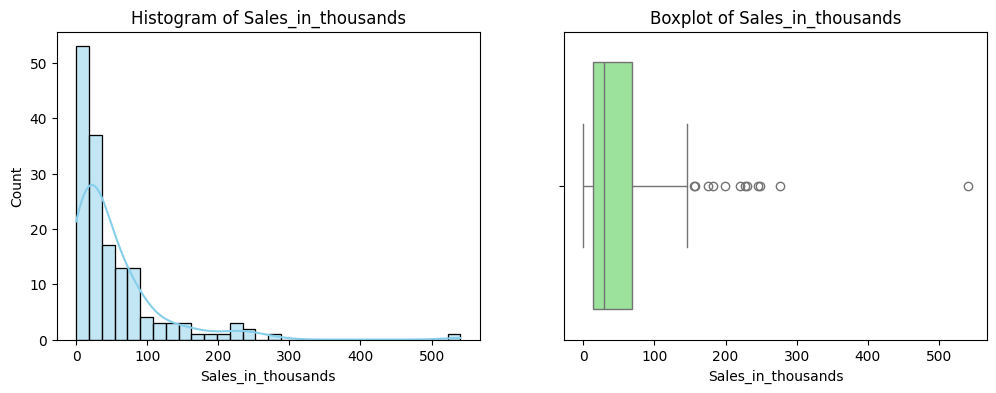


Column: Year_resale_value
Skewness: 2.76
Highly right-skewed


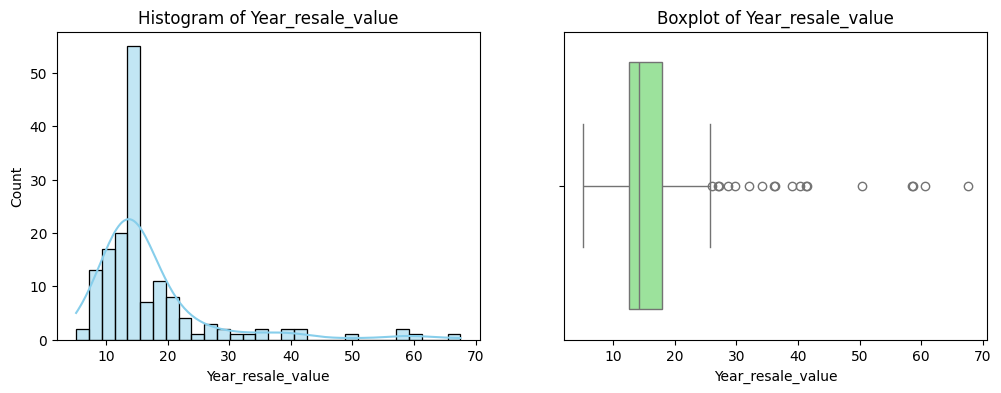


Column: Price_in_thousands
Skewness: 1.78
Highly right-skewed


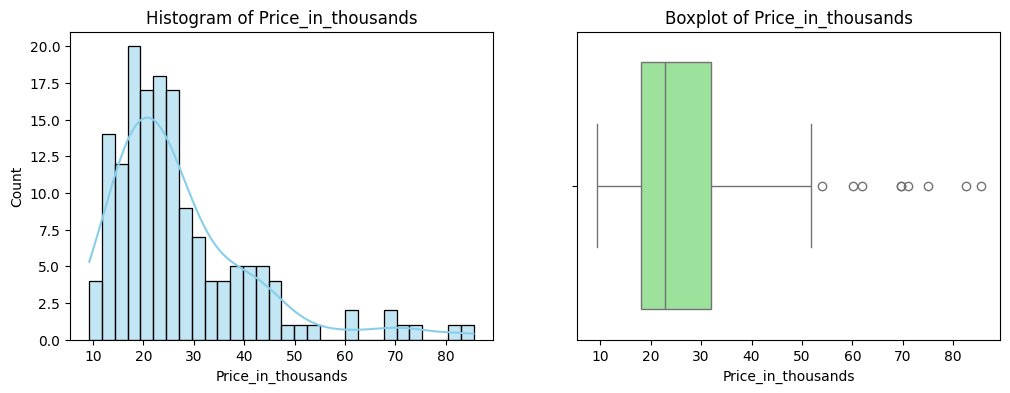


Column: Engine_size
Skewness: 1.10
Highly right-skewed


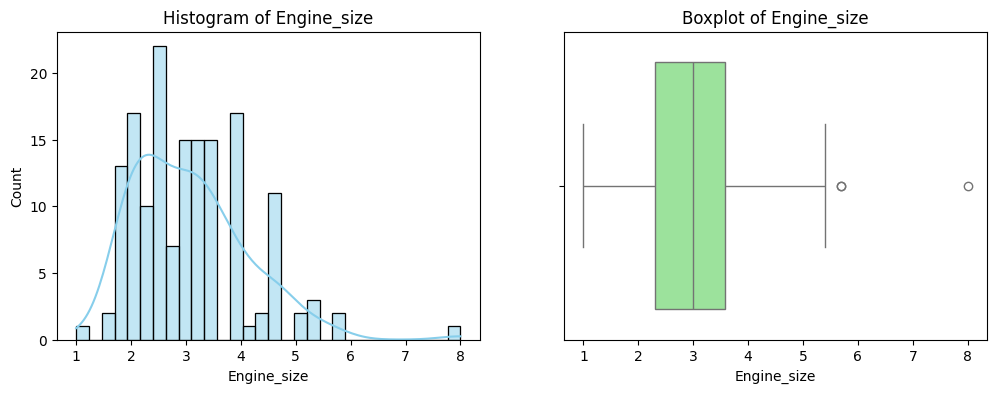


Column: Horsepower
Skewness: 1.00
Highly right-skewed


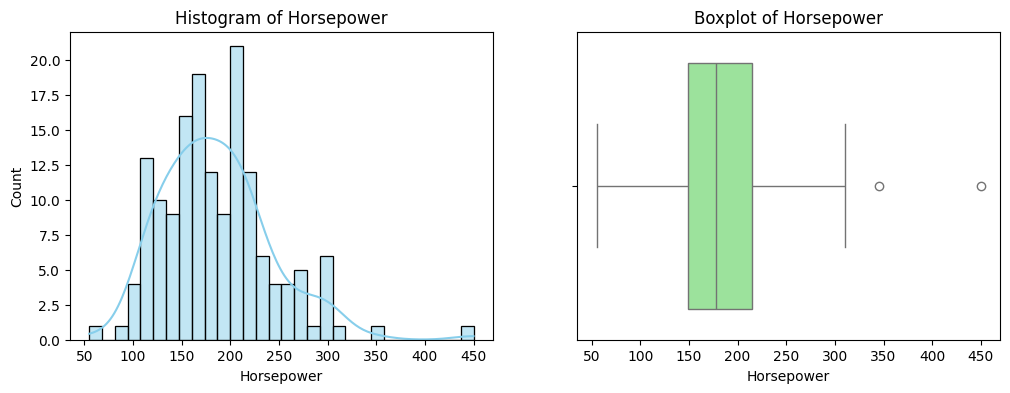


Column: Wheelbase
Skewness: 0.97
Moderately right-skewed


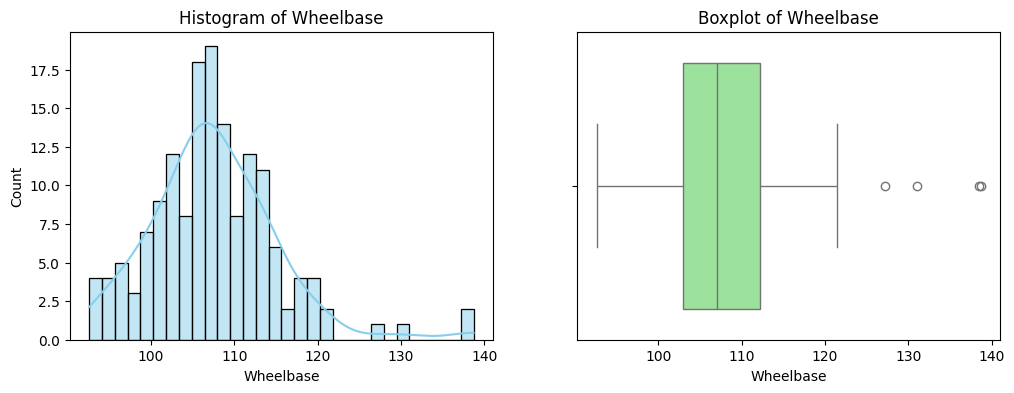


Column: Width
Skewness: 0.48
Approximately symmetric


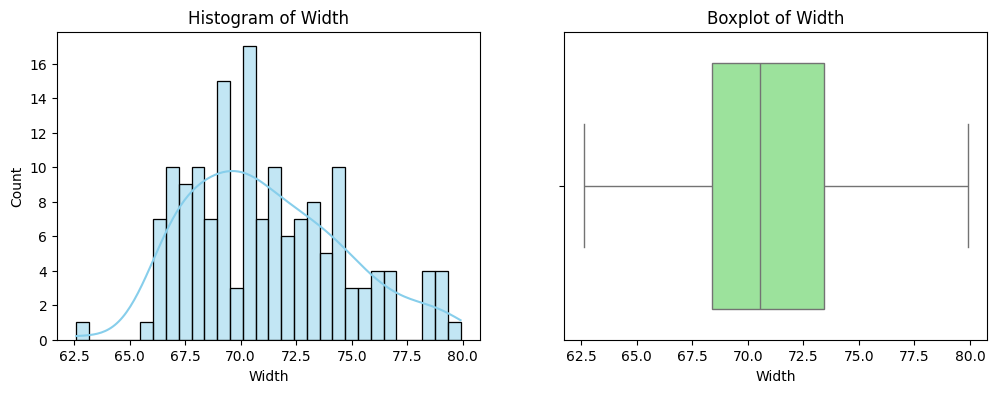


Column: Length
Skewness: -0.06
Approximately symmetric


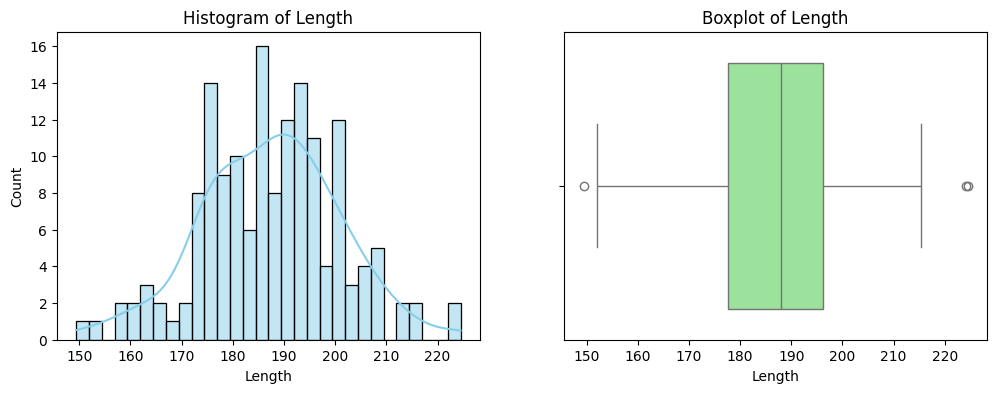


Column: Curb_weight
Skewness: 0.70
Moderately right-skewed


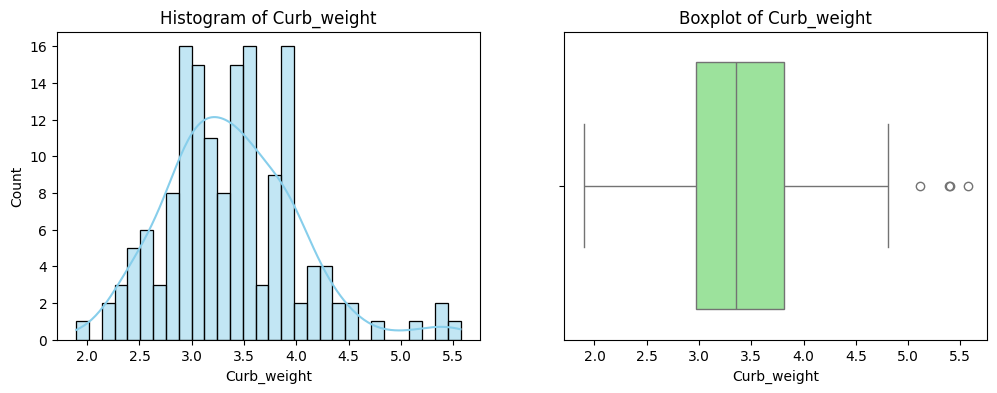


Column: Fuel_capacity
Skewness: 1.14
Highly right-skewed


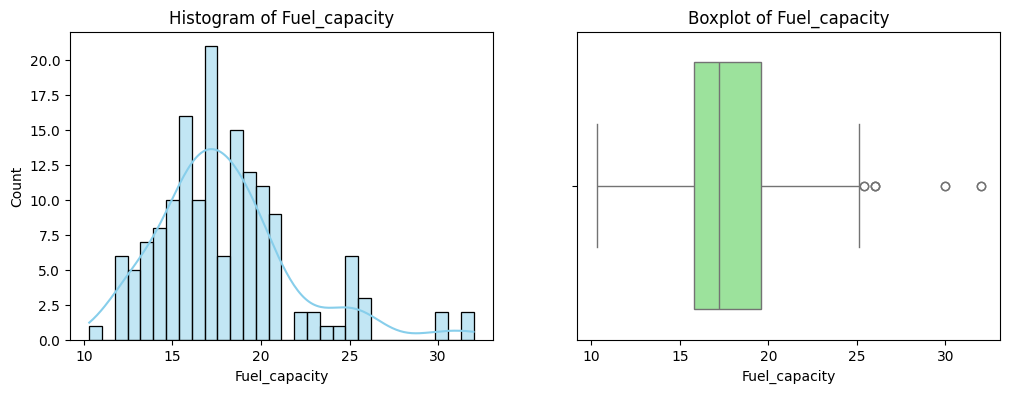


Column: Fuel_efficiency
Skewness: 0.70
Moderately right-skewed


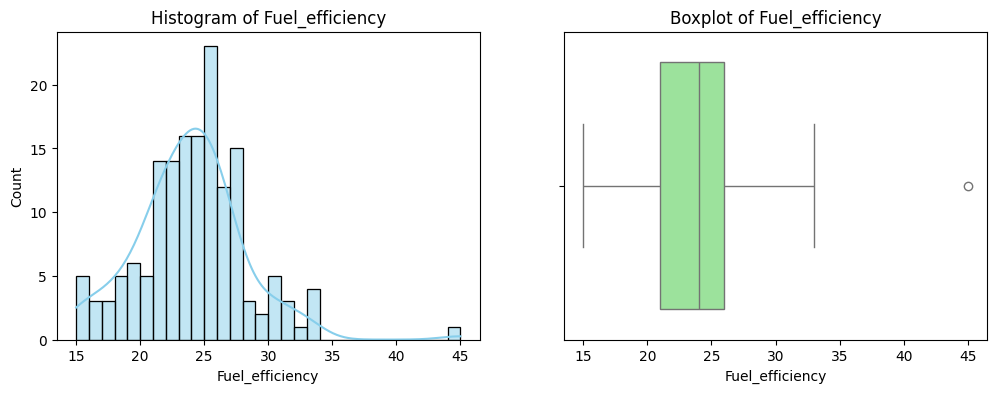


Column: Power_perf_factor
Skewness: 1.08
Highly right-skewed


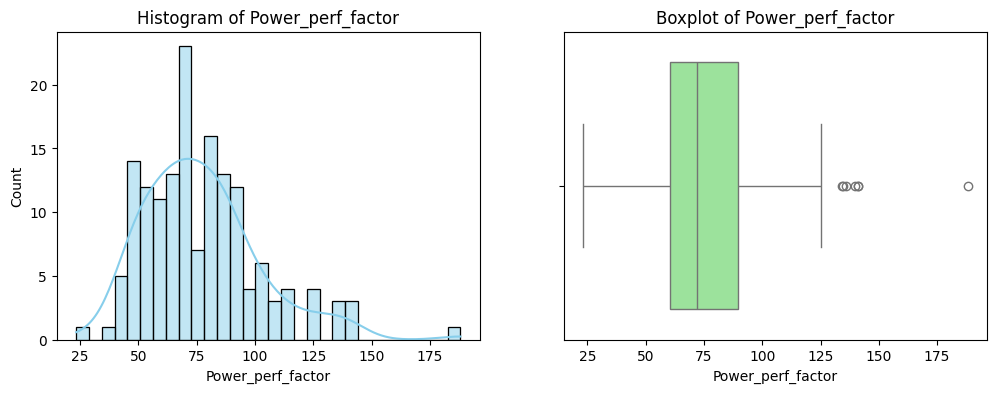

In [20]:
# Univariate Analysis
# Numeric Columns Analysis
numeric_cols = df.select_dtypes(include=np.number).columns

for col in numeric_cols:
    skewness = df[col].skew()

    print(f"\nColumn: {col}")
    print(f"Skewness: {skewness:.2f}")
    
    if skewness > 1:
        print("Highly right-skewed")
    elif skewness > 0.5:
        print("Moderately right-skewed")
    elif skewness < -1:
        print("Highly left-skewed")
    elif skewness < -0.5:
        print("Moderately left-skewed")
    else:
        print("Approximately symmetric")
    
    plt.figure(figsize=(12,4))
    
    # Histogram with KDE
    plt.subplot(1,2,1)
    sns.histplot(df[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Histogram of {col}")
    
    # Boxplot
    plt.subplot(1,2,2)
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f"Boxplot of {col}")
    
    plt.show()


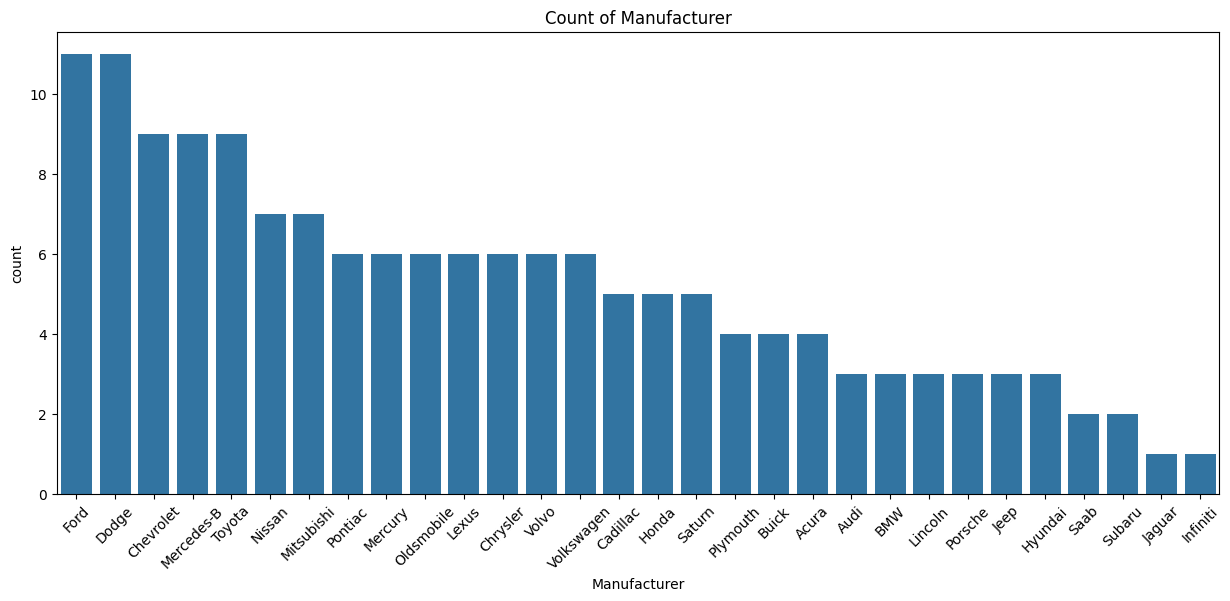

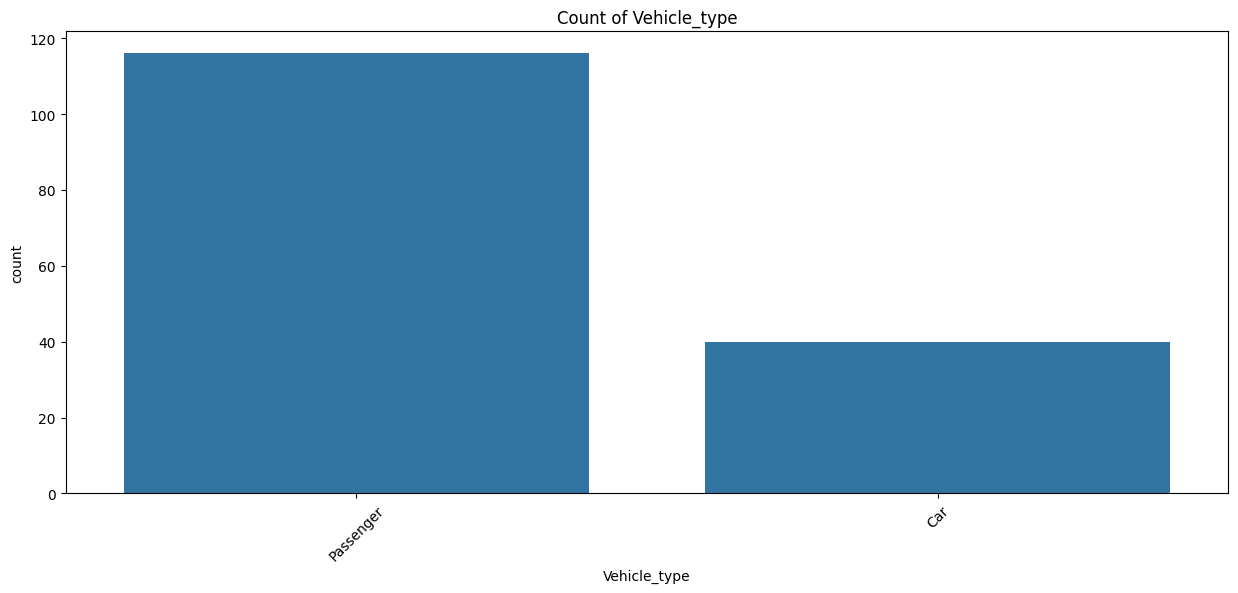

In [24]:
# Categorical Feature Analysis
cat_cols = df.select_dtypes(include='category')

for col in cat_cols:
    plt.figure(figsize=(15,6))
    sns.countplot(data=df, x=col, order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()


Index(['Sales_in_thousands', 'Year_resale_value', 'Price_in_thousands',
       'Engine_size', 'Horsepower', 'Wheelbase', 'Width', 'Length',
       'Curb_weight', 'Fuel_capacity', 'Fuel_efficiency', 'Power_perf_factor'],
      dtype='object')


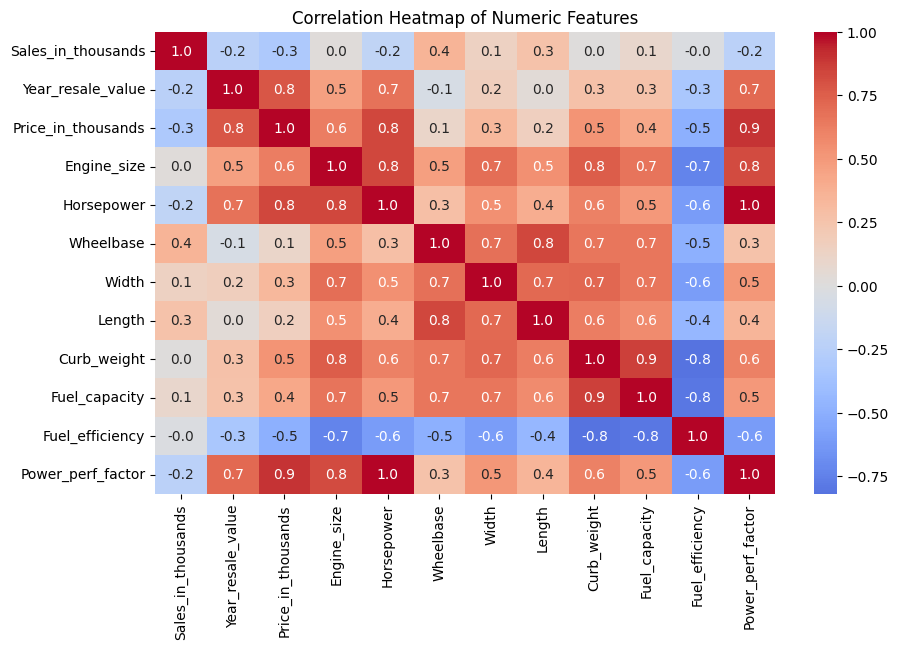

In [39]:
# Bivariate Analysis
# Correlation heatmap for numeric variables

numeric_cols = df.select_dtypes(include=np.number).columns
print(numeric_cols)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", center=0, fmt='.1f');
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

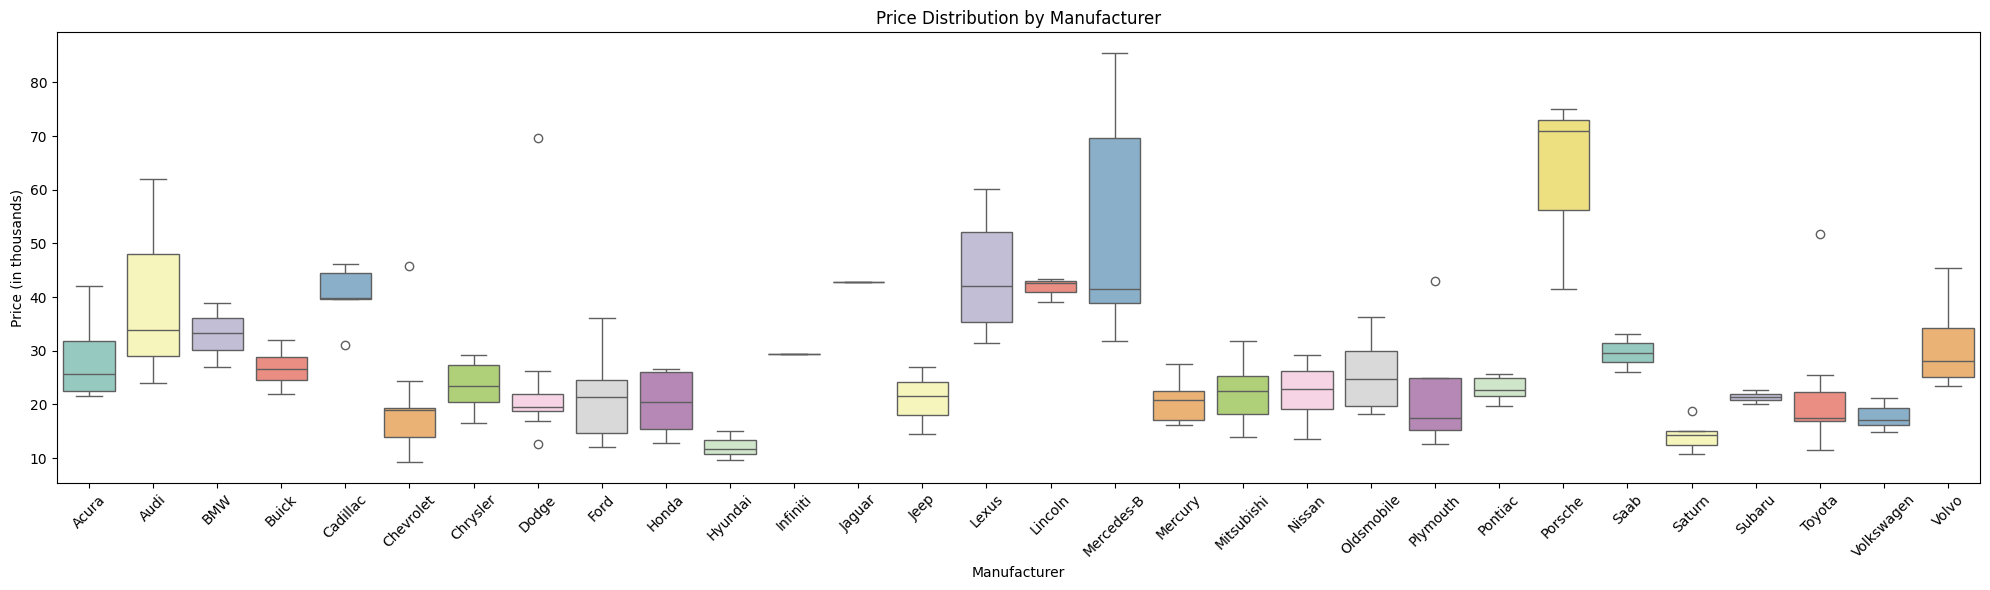

<Figure size 2000x600 with 0 Axes>

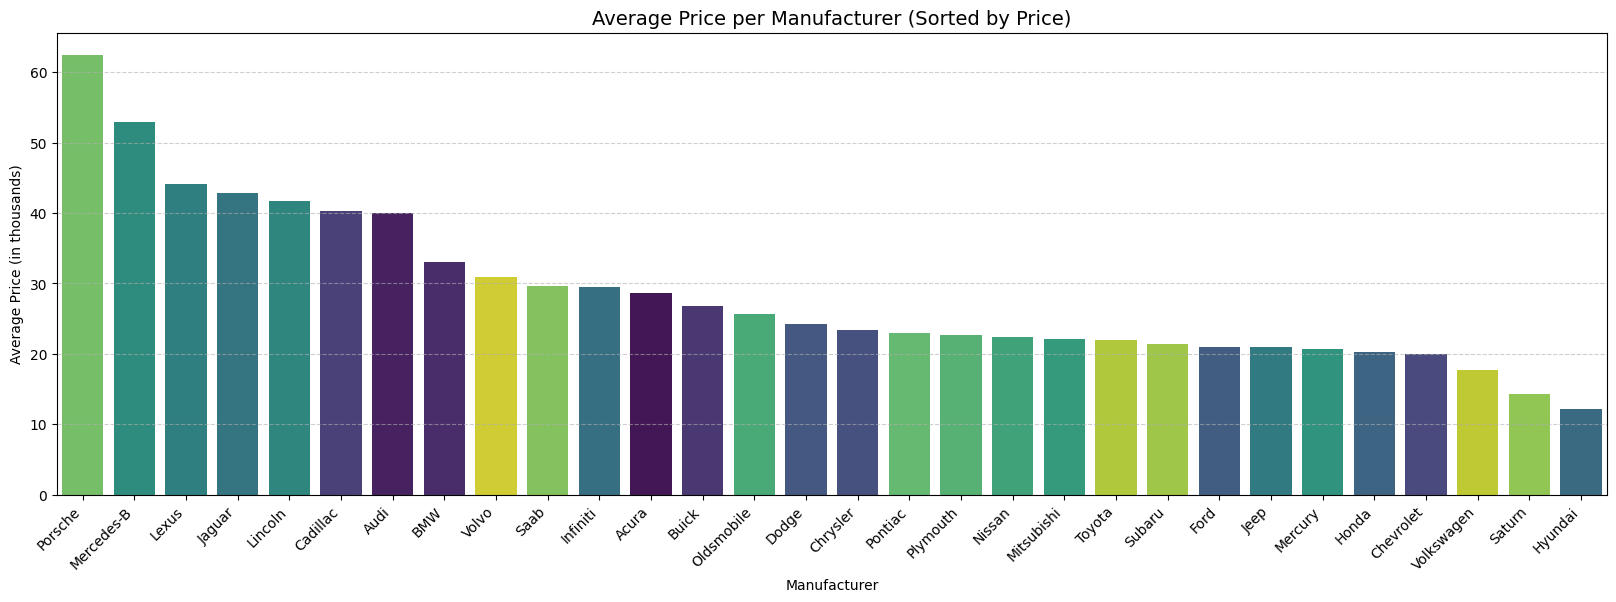

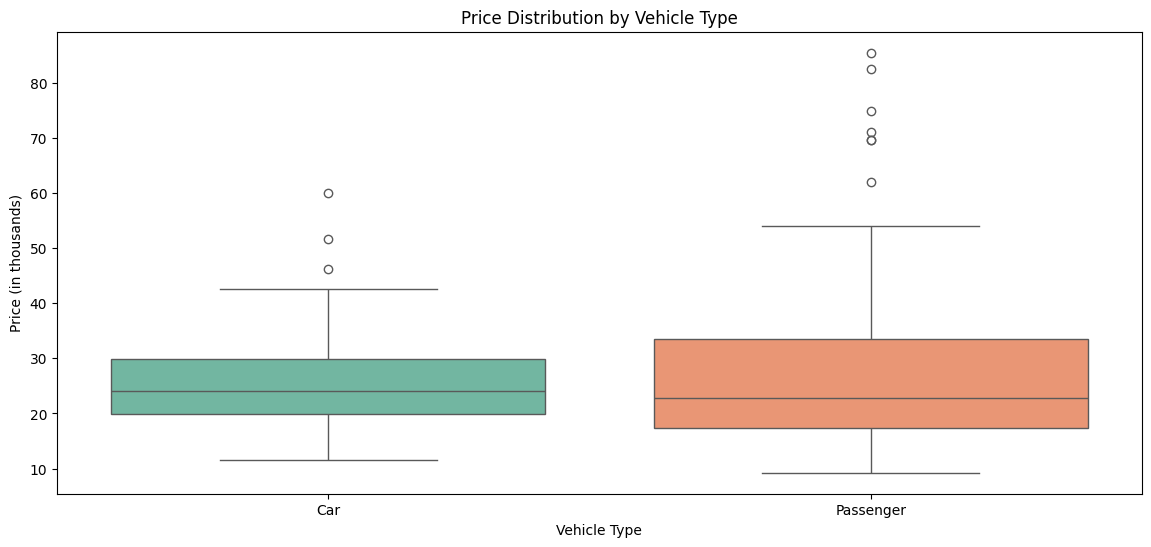

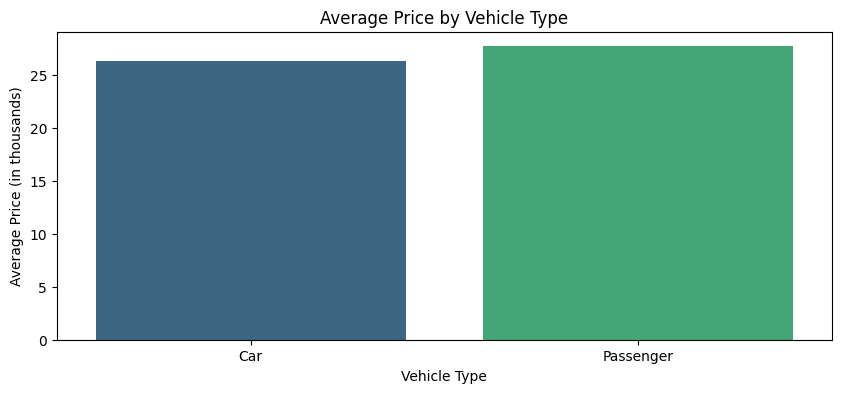

In [74]:
# Price Analysis (Categorical Features)
# Does Manufacturer significantly influence Price

# Manufacturer vs Price (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(data=df, x="Manufacturer", y="Price_in_thousands", hue="Manufacturer", 
            palette='Set3');
plt.xticks(rotation=45)
plt.title("Price Distribution by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Price (in thousands)")
plt.tight_layout()
plt.show()

# Which manufacturer has the highest average Price
# Average Price per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by average price
manufacturer_price_df = (df.groupby('Manufacturer', observed=True)['Price_in_thousands']
                         .mean().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_price_df['Manufacturer']

plt.figure(figsize=(20,6))
# Plotting the pre-sorted DataFrame with explicit order
sns.barplot(
    data=manufacturer_price_df,
    x="Manufacturer",
    y="Price_in_thousands",
    order=manufacturer_order_list,  # guarantees sorting
    hue="Manufacturer",
    legend=False,
    palette='viridis'
);

plt.xticks(rotation=45, ha='right')
plt.title("Average Price per Manufacturer (Sorted by Price)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Average Price (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are prices linked to Vehicle_Type? (Boxplot for Price Distribution)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Price_in_thousands", hue="Vehicle_type", palette='Set2');
plt.title("Price Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Price (in thousands)")
plt.show()


# Vehicle Type vs Average Price (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(data=df, x='Vehicle_type', y='Price_in_thousands', hue='Vehicle_type', errorbar=None, palette='viridis');
plt.title("Average Price by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Average Price (in thousands)")
plt.show()

Selected price-driving features: ['Year_resale_value', 'Engine_size', 'Horsepower', 'Curb_weight', 'Fuel_efficiency', 'Power_perf_factor']


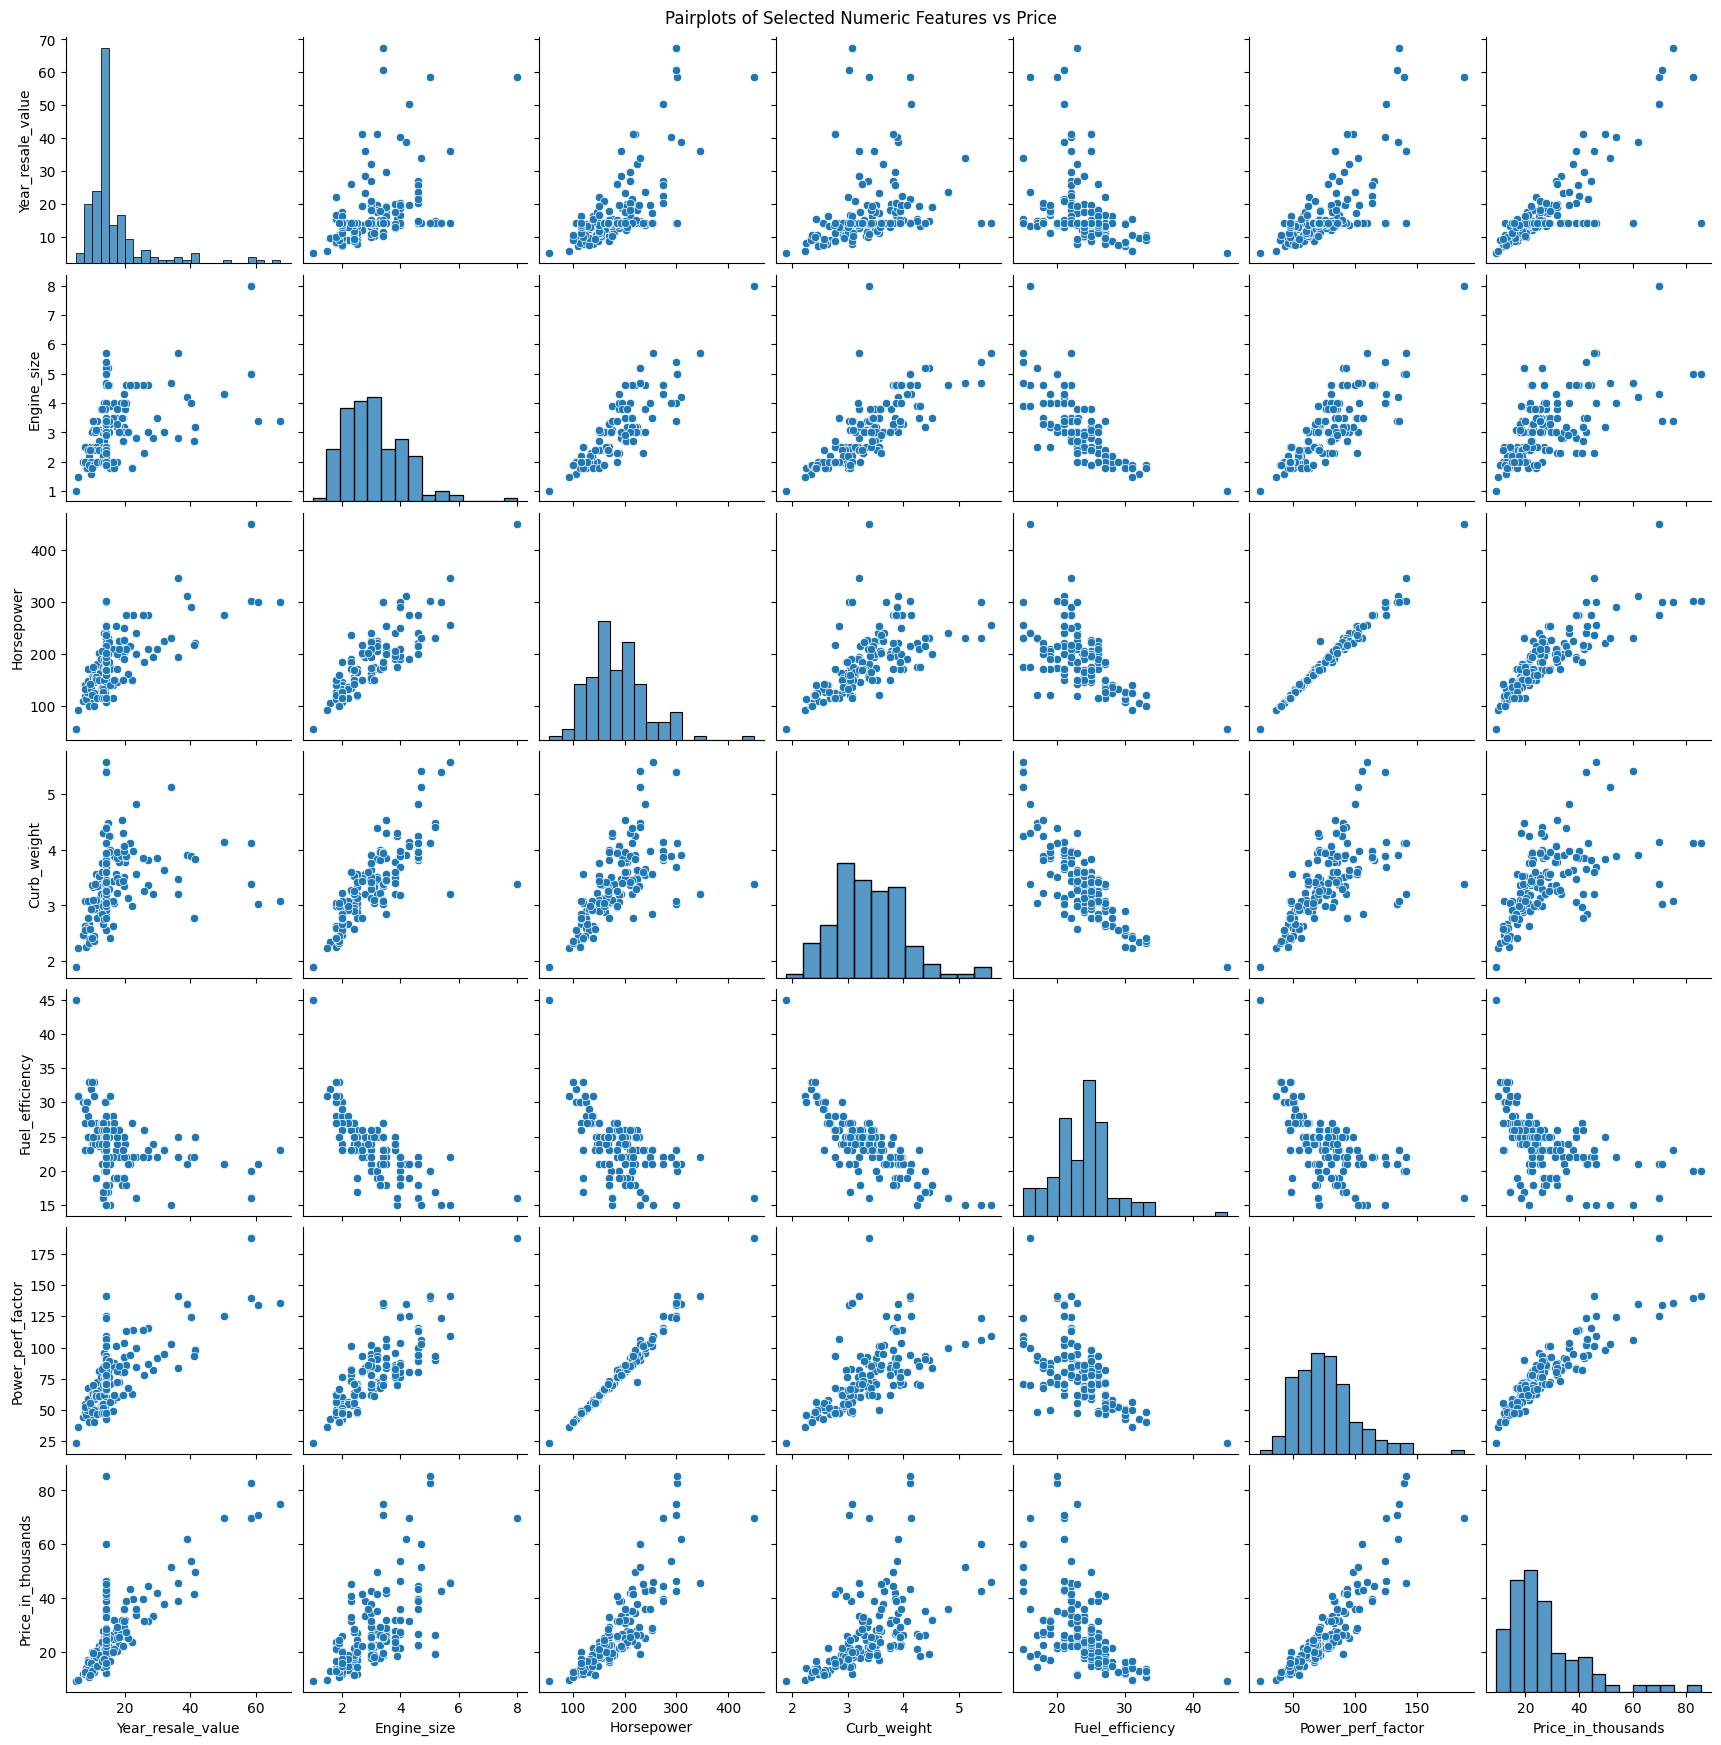

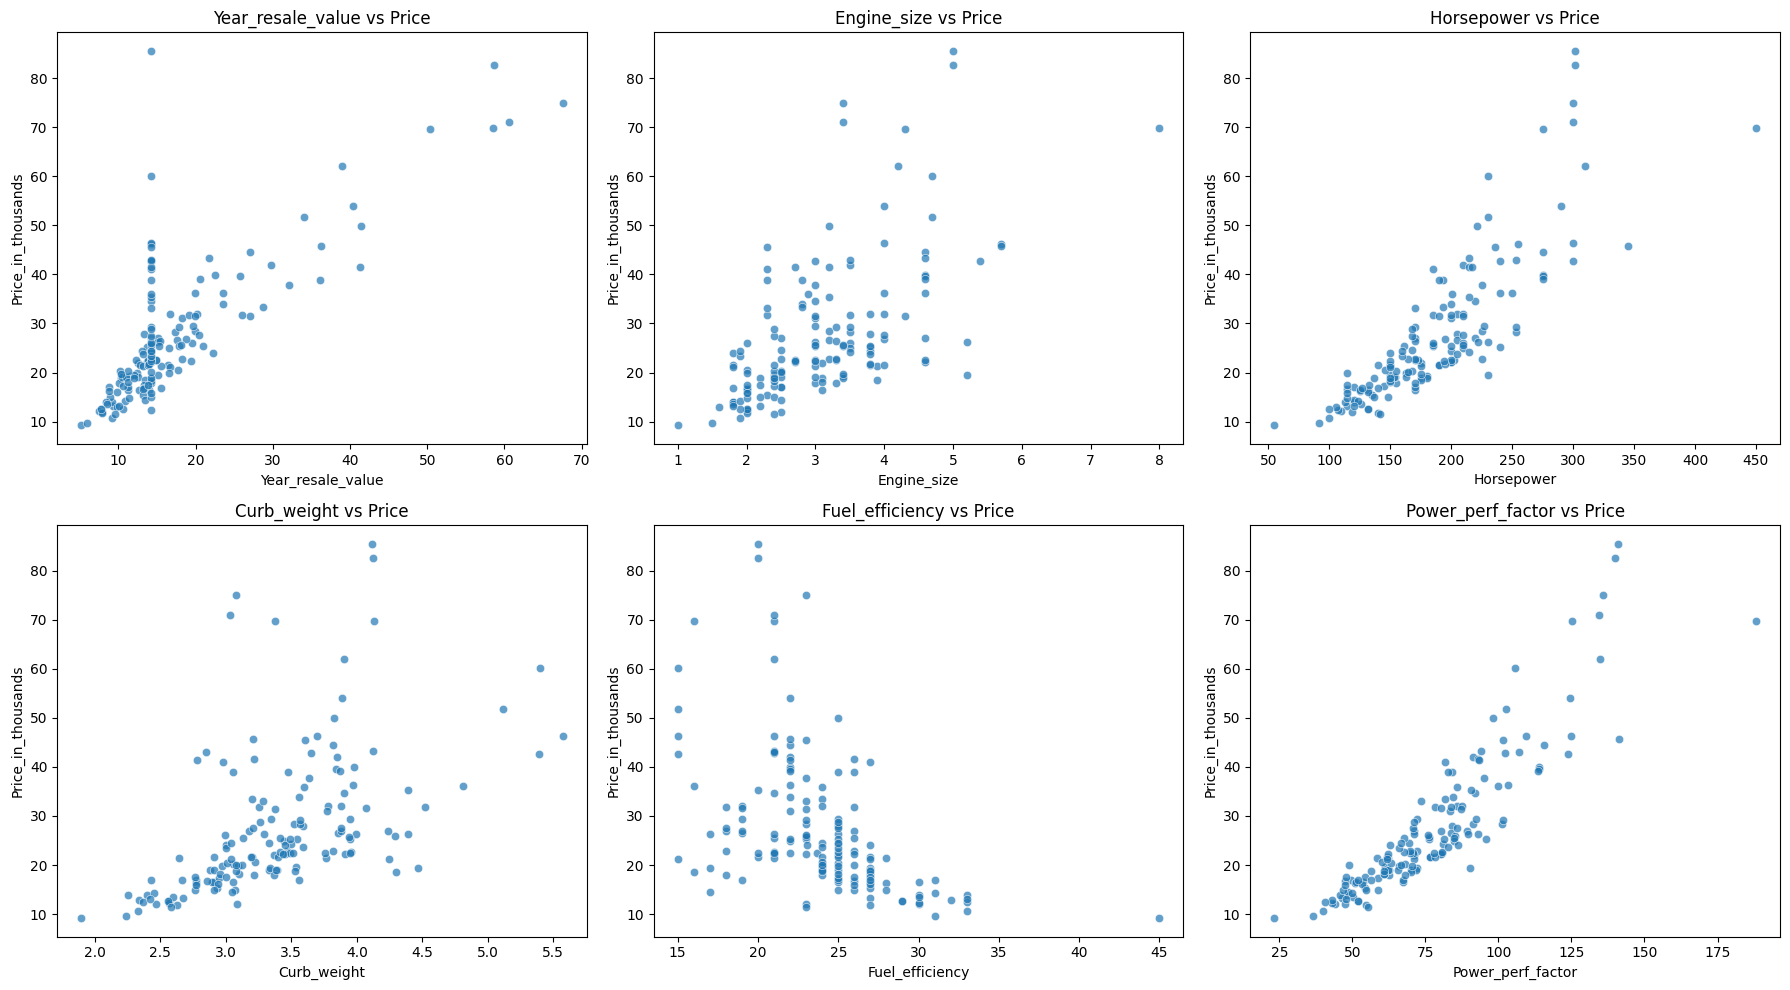

In [41]:
# What features influence car prices the most?

numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr().round(1)         # Correlation matrix

# Extract correlations with Price
price_corr = corr_matrix["Price_in_thousands"].drop("Price_in_thousands")

# Select features with |correlation| >= 0.5
selected_price_features = price_corr[price_corr.abs() >= 0.5].index.tolist()
print("Selected price-driving features:", selected_price_features)

# Pairplot of selected features + Price
sns.pairplot(df[selected_price_features + ["Price_in_thousands"]])
plt.suptitle("Pairplots of Selected Numeric Features vs Price", y=1)
plt.show()

# Scatterplots: all selected features vs Price in one figure
n_features = len(selected_price_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # auto-calc rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(selected_price_features):
    sns.scatterplot(x=feature, y="Price_in_thousands", data=df, ax=axes[i], alpha=0.7)
    axes[i].set_title(f"{feature} vs Price")

# Hide unused axes (if features < grid size)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

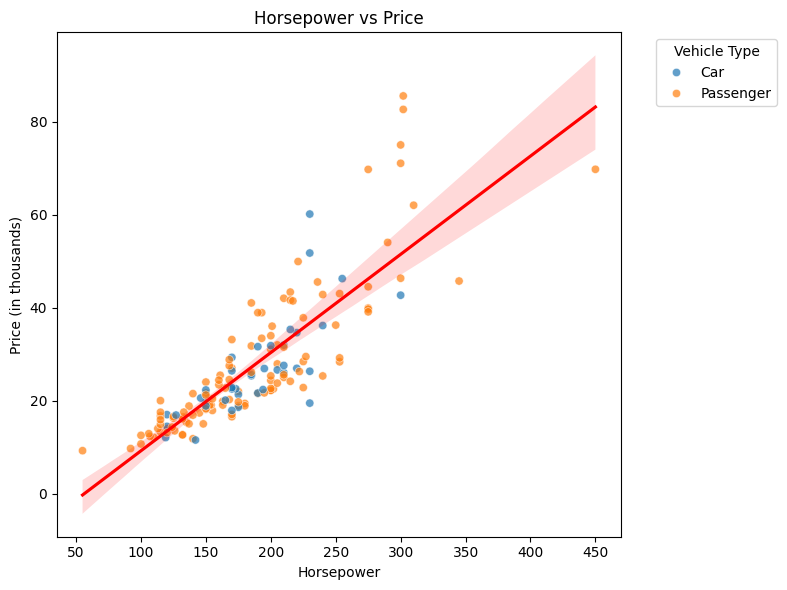

In [50]:
# How does Horsepower relate to Price
# Scatterplot + Regression line: Horsepower vs Price by Vehicle_Type

if 'Horsepower' in df.columns and 'Price_in_thousands' in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x='Horsepower', y='Price_in_thousands', hue='Vehicle_type', alpha=0.7)
    sns.regplot(data=df, x='Horsepower', y='Price_in_thousands', scatter=False, color='red')
    plt.title("Horsepower vs Price")
    plt.xlabel("Horsepower")
    plt.ylabel("Price (in thousands)")
    plt.legend(title="Vehicle Type", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


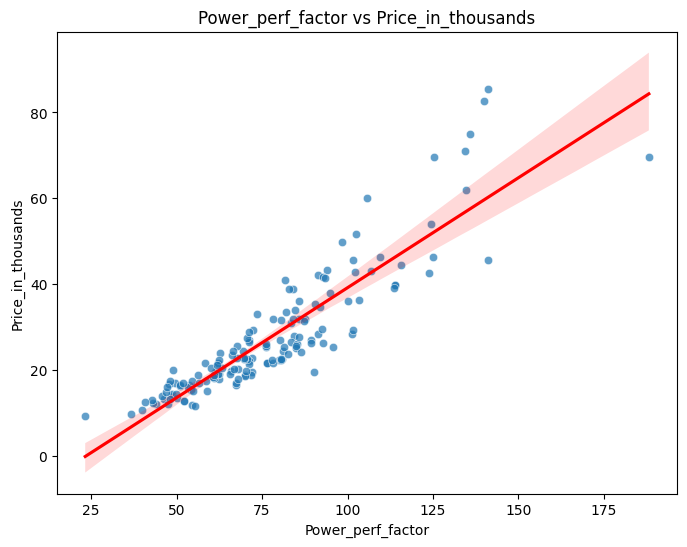

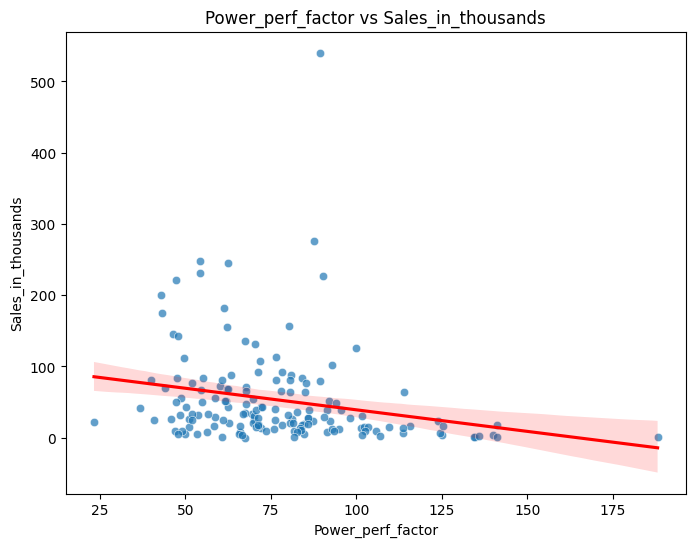

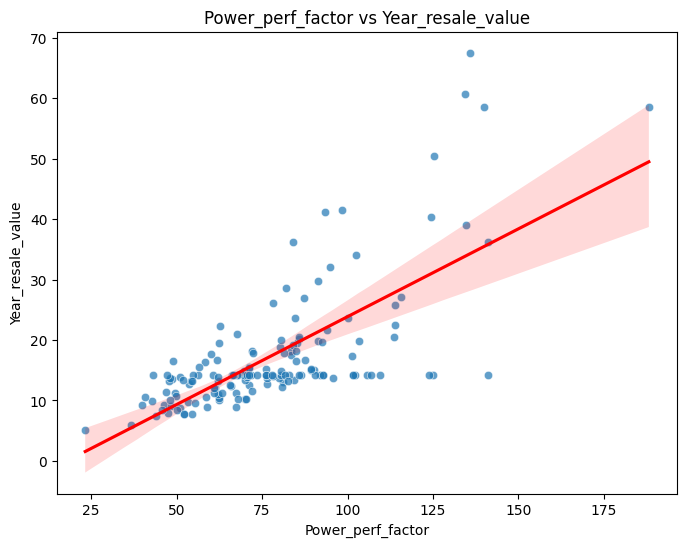

In [55]:
# Power_perf_factor vs. Key Business Metrics
# Addresses: Performance correlation with Price, Sales, and Resale.

# Define target variables
targets = ['Price_in_thousands', 'Sales_in_thousands', 'Year_resale_value']

for target in targets:
    if 'Power_perf_factor' in df.columns and target in df.columns:
        # Scatterplot with regression line
        plt.figure(figsize=(8,6))
        sns.scatterplot(data=df, x='Power_perf_factor', y=target, alpha=0.7)
        sns.regplot(data=df, x='Power_perf_factor', y=target, scatter=False, color='red')
        plt.title(f"Power_perf_factor vs {target}")
        plt.xlabel("Power_perf_factor")
        plt.ylabel(target)
        plt.show()


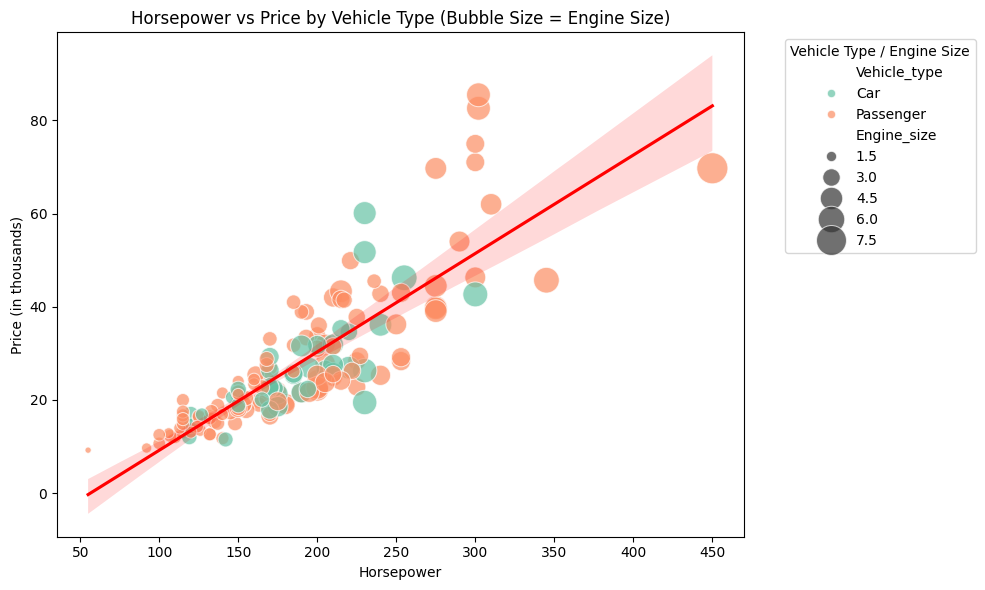

In [ ]:
# Do more powerful cars command higher prices?
# Ensure required columns exist
required_cols = ['Horsepower', 'Price_in_thousands', 'Engine_size', 'Vehicle_type']
if all(col in df.columns for col in required_cols):

    # Scatterplot: Horsepower vs Price
    plt.figure(figsize=(10,6))
    sns.scatterplot(
        data=df,
        x='Horsepower',
        y='Price_in_thousands',
        hue='Vehicle_type',       # color by Vehicle Type
        size='Engine_size',       # size by Engine Size
        palette='Set2',
        alpha=0.7,
        sizes=(20, 500)
    )
    
    # Regression line (overall trend)
    sns.regplot(data=df, x='Horsepower', y='Price_in_thousands', scatter=False, color='red')
    
    plt.title("Horsepower vs Price by Vehicle Type (Bubble Size = Engine Size)")
    plt.xlabel("Horsepower")
    plt.ylabel("Price (in thousands)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Vehicle Type / Engine Size")
    plt.tight_layout()
    plt.show()
    

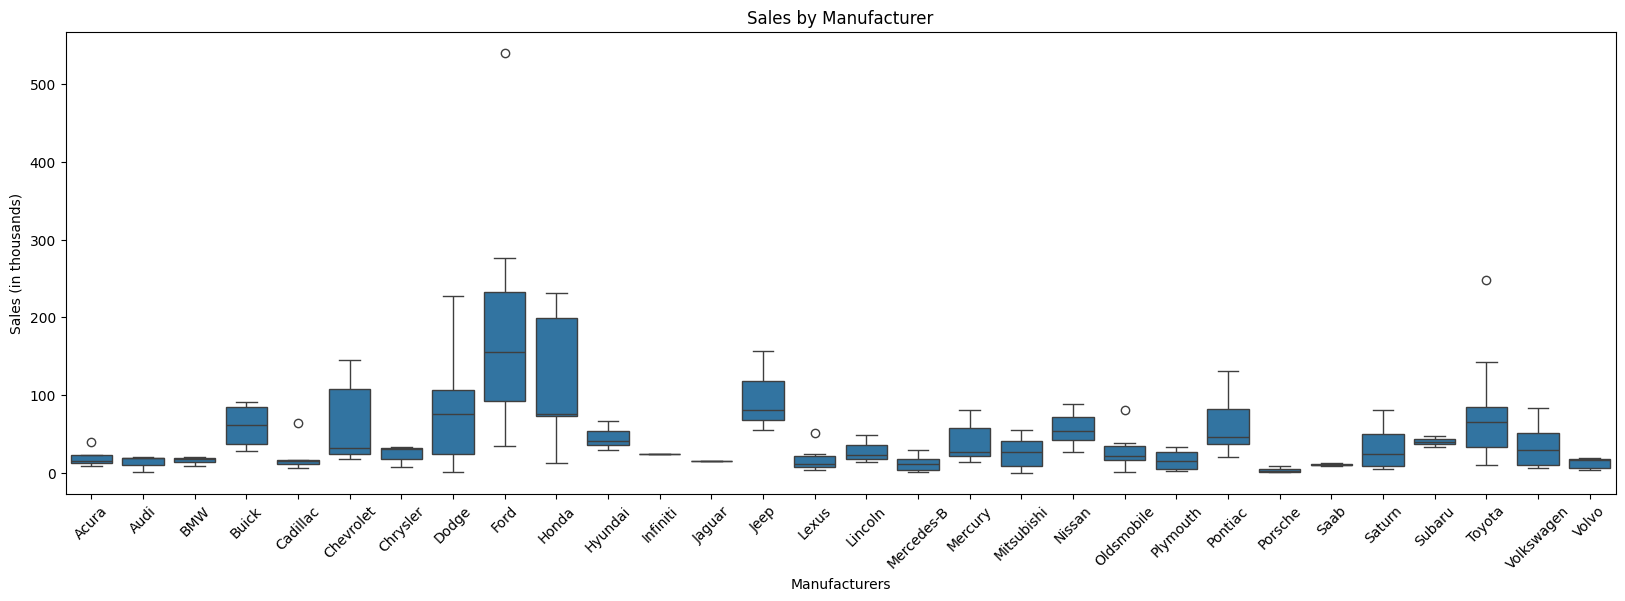

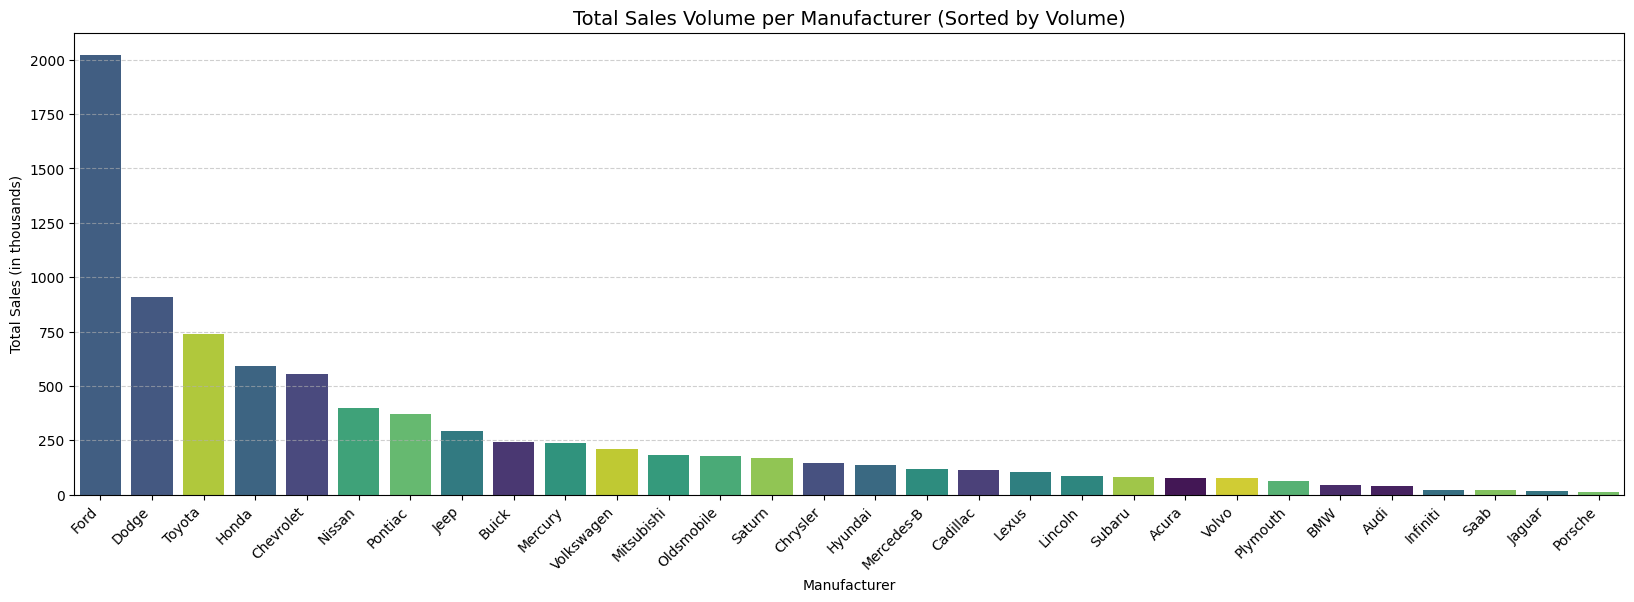

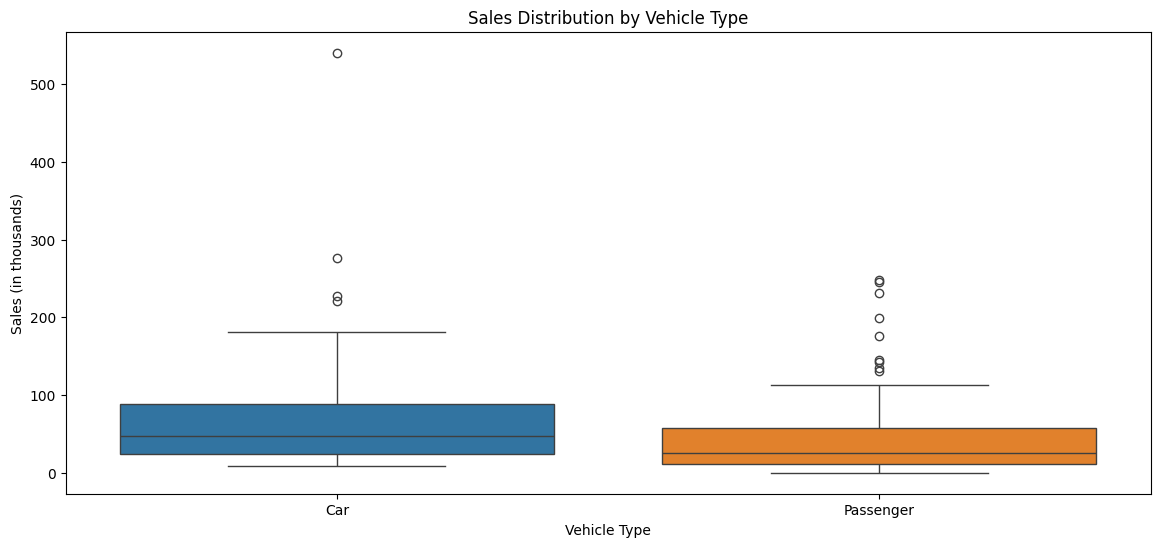

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/372671167.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vehicle_type', y='Sales_in_thousands', data=df, errorbar=None, palette='viridis' )


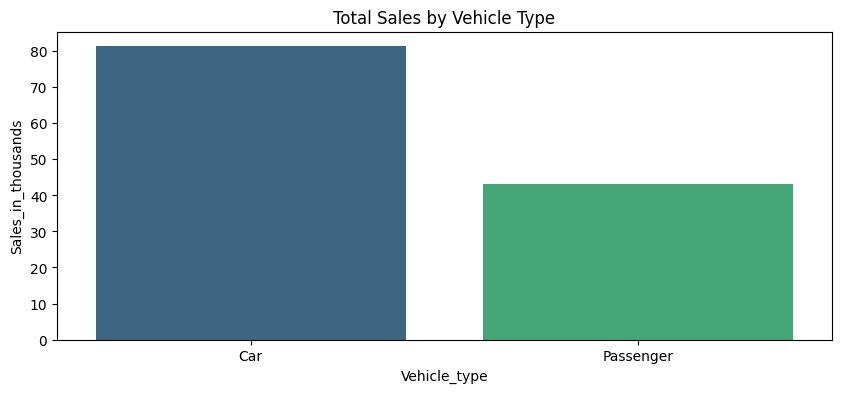

In [ ]:
# Sales Analysis (Categorical Features)
# Does Manufacturer significantly influence Sales

# Manufacturer vs Sales (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(x="Manufacturer", y="Sales_in_thousands", data=df)
plt.xticks(rotation=45)
plt.title("Sales by Manufacturer")
plt.xlabel("Manufacturers")
plt.ylabel("Sales (in thousands)")
plt.show()

# Which manufacturer dominates the sales volume
# Average Sales per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by sales (creates the small, sorted summary table)
manufacturer_sales_df = (df.groupby('Manufacturer', observed=True)['Sales_in_thousands'].sum().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_sales_df['Manufacturer']

# Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_sales_df,
    x="Manufacturer",
    y="Sales_in_thousands",
    order=manufacturer_order_list, # GUARANTEES THE SORTING
    hue="Manufacturer", 
    legend=False,
    palette='viridis' 
)

plt.xticks(rotation=45, ha='right')
plt.title("Total Sales Volume per Manufacturer (Sorted by Volume)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Total Sales (in thousands)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are sales linked to Vehicle_Type? (Boxplot for Sales Distribution)
# Vehicle Type vs Sales (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Sales_in_thousands", hue="Vehicle_type")
plt.xticks()
plt.title("Sales Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Sales (in thousands)")
plt.show()

# Vehicle Type vs Price (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_type', y='Sales_in_thousands', data=df, errorbar=None, palette='viridis' )
plt.title(f"Total by Vehicle Type")
plt.show()

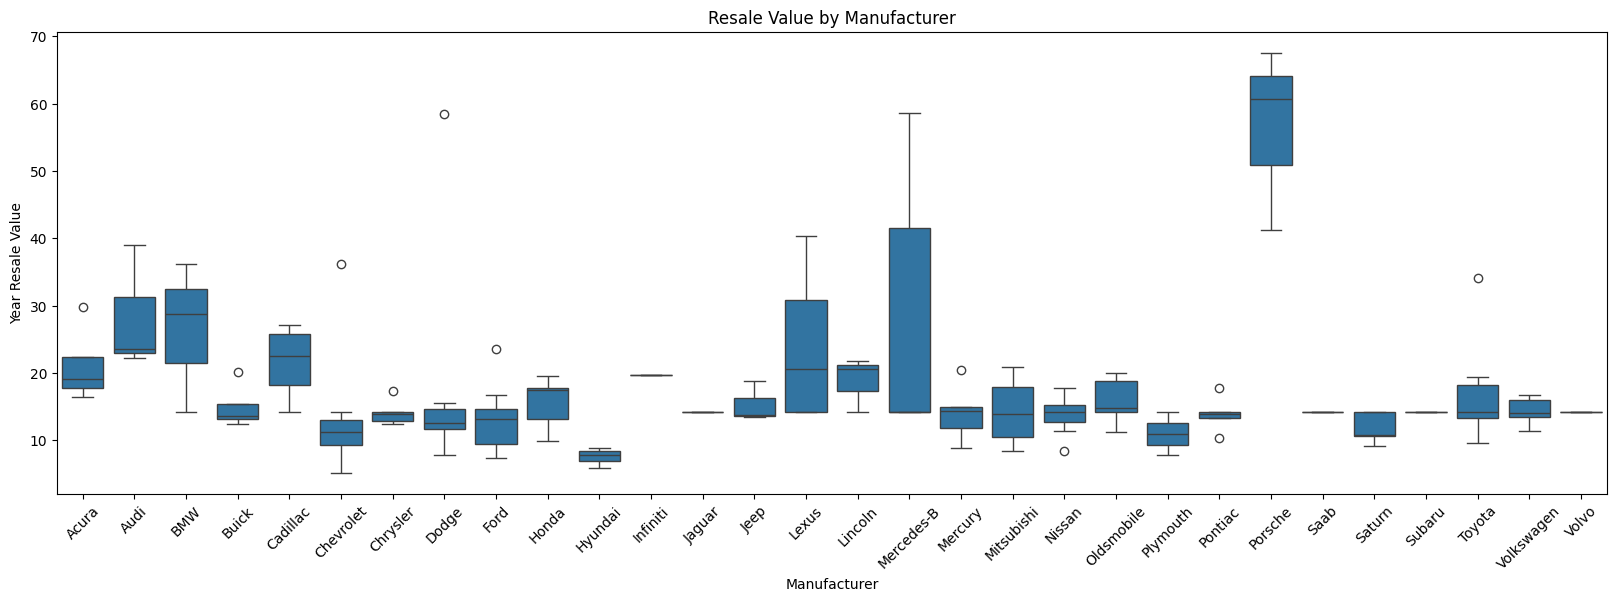

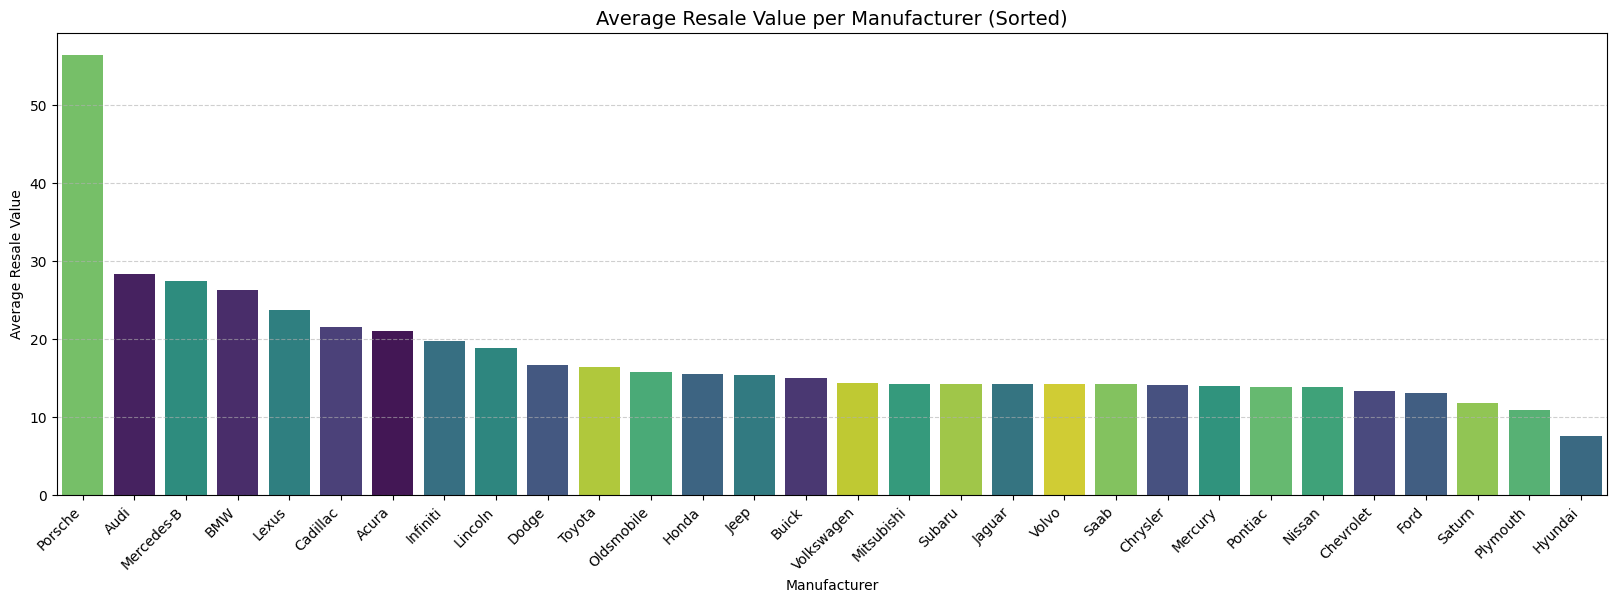

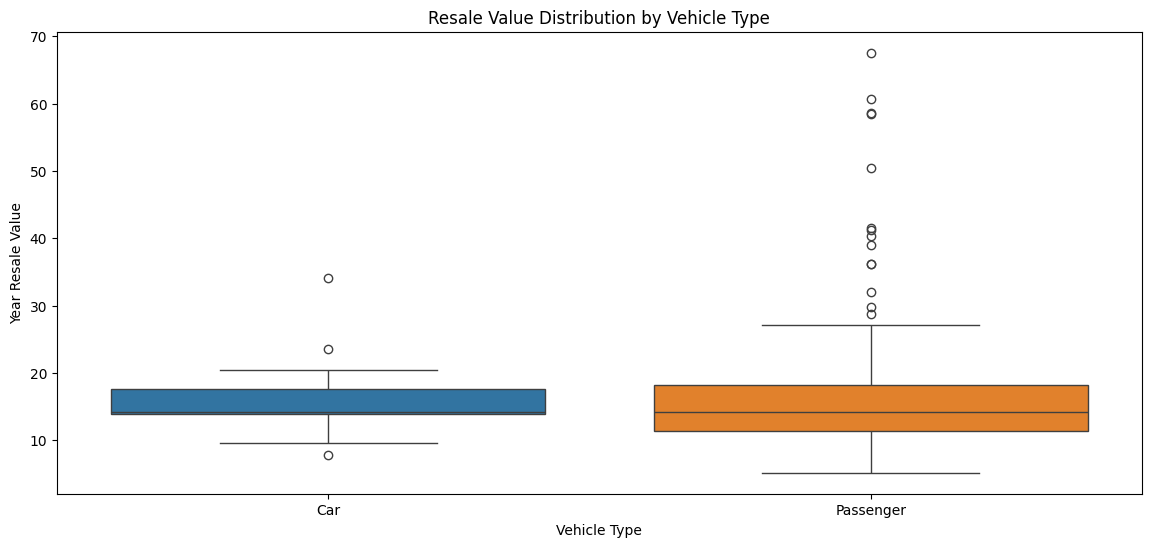

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/3257558549.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Vehicle_type', y='Year_resale_value', data=df, errorbar=None, palette='viridis' )


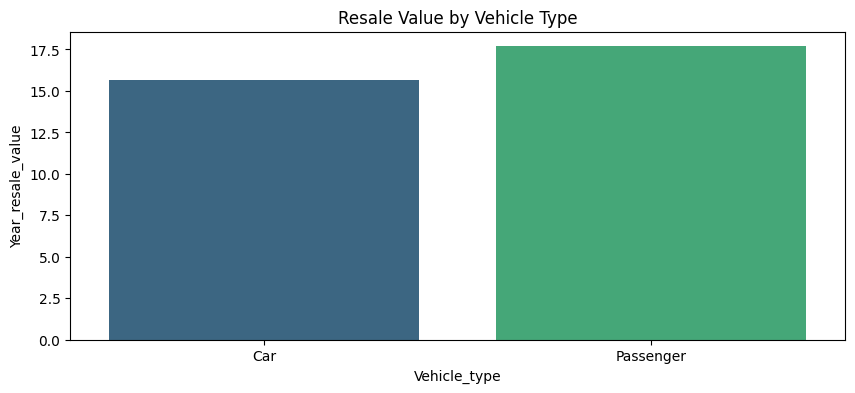

In [23]:
# Resales Analysis (Categorical Features)
# Does Manufacturer significantly influence Resales

# Manufacturer vs Resales (Boxplot)
plt.figure(figsize=(20,6))
sns.boxplot(x="Manufacturer", y="Year_resale_value", data=df)
plt.xticks(rotation=45)
plt.title("Resale Value by Manufacturer")
plt.xlabel("Manufacturer")
plt.ylabel("Year Resale Value")
plt.show()

# Which manufacturer dominates the resale values
# Average Resales Value per Manufacturer (Barplot)
plt.figure(figsize=(20,6))

# Aggregate and sort by sales (creates the small, sorted summary table)
manufacturer_resale_df = (df.groupby('Manufacturer', observed=True)['Year_resale_value'].mean().sort_values(ascending=False).reset_index())

# Extract the sorted list of Manufacturer names for explicit order
manufacturer_order_list = manufacturer_resale_df['Manufacturer']

# Plotting the PRE-SORTED DataFrame with explicit order
sns.barplot(
    data=manufacturer_resale_df,
    x="Manufacturer",
    y="Year_resale_value",
    order=manufacturer_order_list, # GUARANTEES THE SORTING
    hue="Manufacturer", 
    legend=False,
    palette='viridis' 
)

plt.xticks(rotation=45, ha='right')
plt.title("Average Resale Value per Manufacturer (Sorted)", fontsize=14)
plt.xlabel("Manufacturer")
plt.ylabel("Average Resale Value")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

# Are resales linked to Vehicle_Type? (Boxplot for ReSale Distribution)
# Vehicle Type vs Sales (Boxplot)
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="Vehicle_type", y="Year_resale_value", hue="Vehicle_type")
plt.xticks()
plt.title("Resale Value Distribution by Vehicle Type")
plt.xlabel("Vehicle Type")
plt.ylabel("Year Resale Value")
plt.show()

# Vehicle Type vs Resale Value (Barplot)
plt.figure(figsize=(10,4))
sns.barplot(x='Vehicle_type', y='Year_resale_value', data=df, errorbar=None, palette='viridis' )
plt.title(f"Resale Value by Vehicle Type")
plt.show()

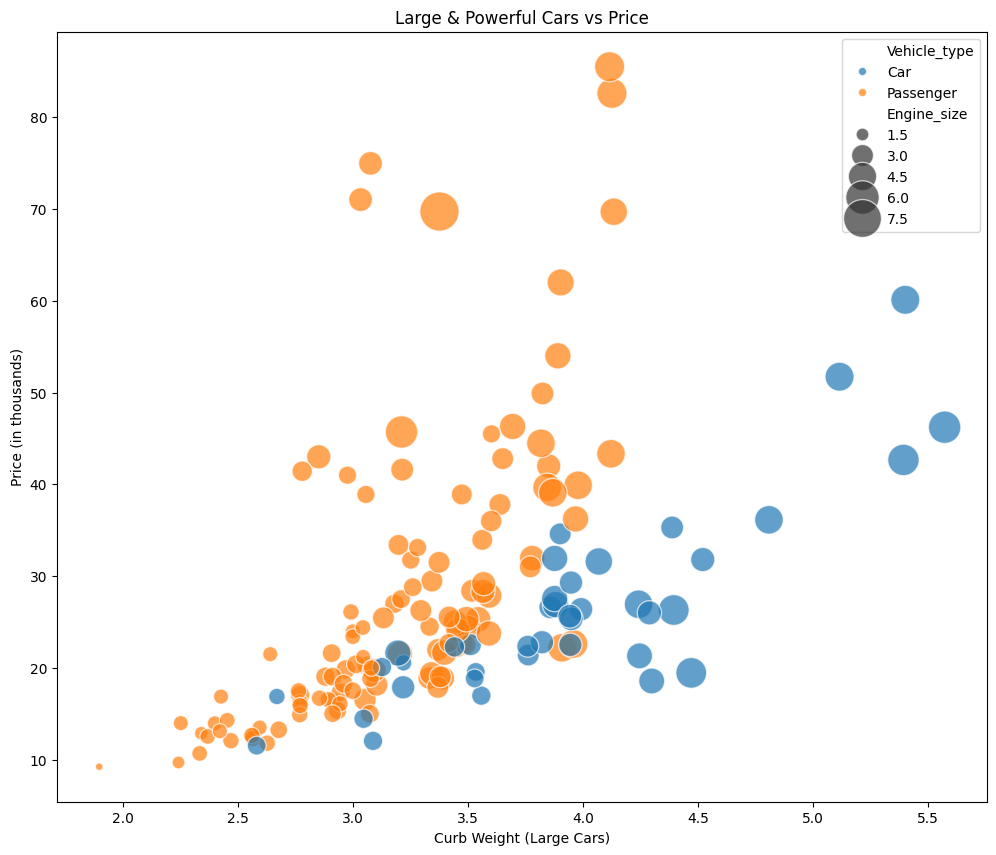

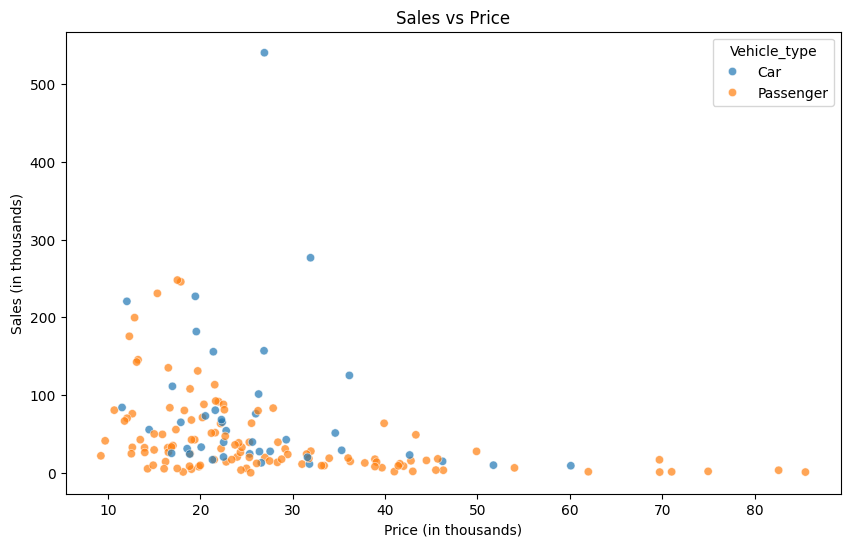

In [29]:
# What is the relationship between Price and Sales

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Price_in_thousands', y='Sales_in_thousands', hue='Vehicle_type',alpha=0.7)
plt.title("Sales vs Price")
plt.xlabel("Price (in thousands)")
plt.ylabel("Sales (in thousands)")
plt.show()

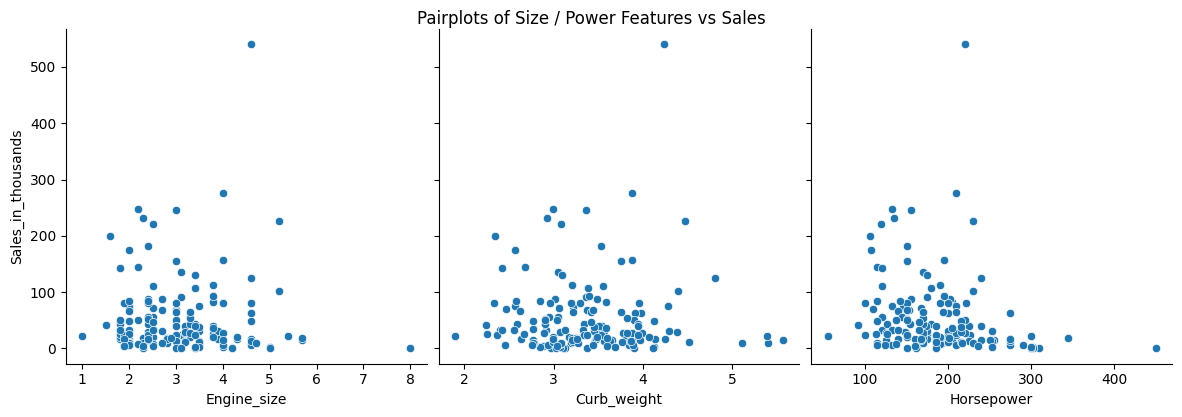

In [30]:
# Do larger / more powerful cars sell better than smaller ones?

# Drop rows with missing numeric data
df_sales = df[["Sales_in_thousands", "Engine_size", "Curb_weight", 
               "Horsepower", "Price_in_thousands"]].dropna()


# Optional: Pairplot of sales vs numeric features
sns.pairplot(df_sales, x_vars=["Engine_size","Curb_weight","Horsepower"], 
             y_vars=["Sales_in_thousands"], height=4, aspect=1, kind="scatter")
plt.suptitle("Pairplots of Size / Power Features vs Sales", y=1.02)
plt.show()


Selected price-driving features: ['Price_in_thousands', 'Engine_size', 'Horsepower', 'Power_perf_factor']


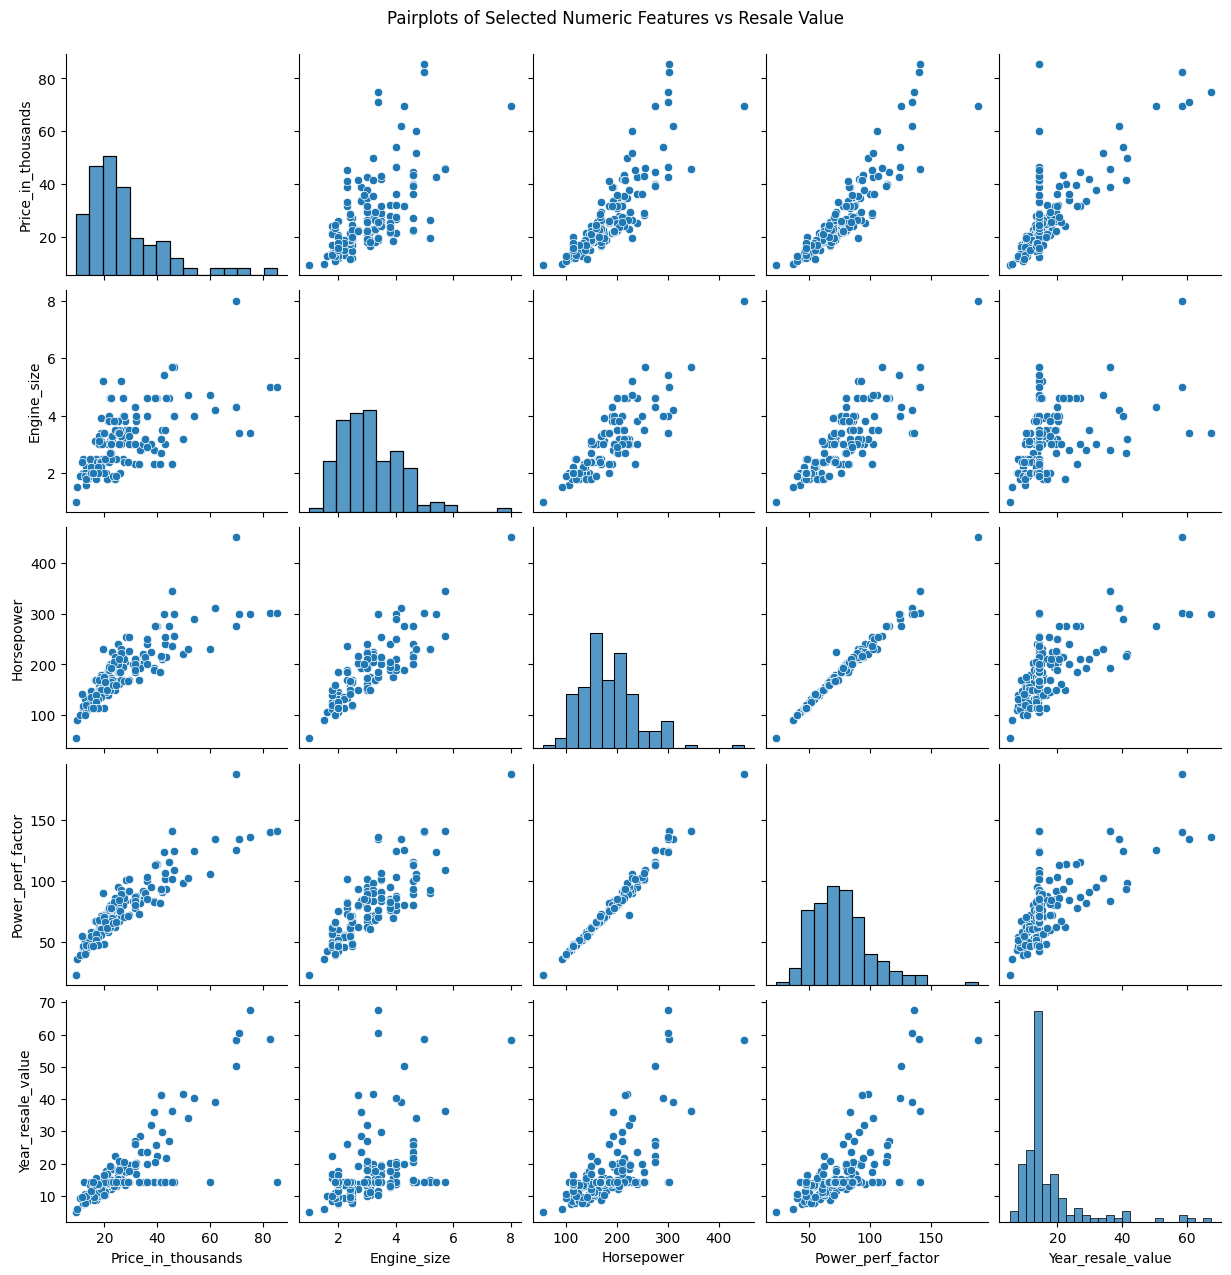

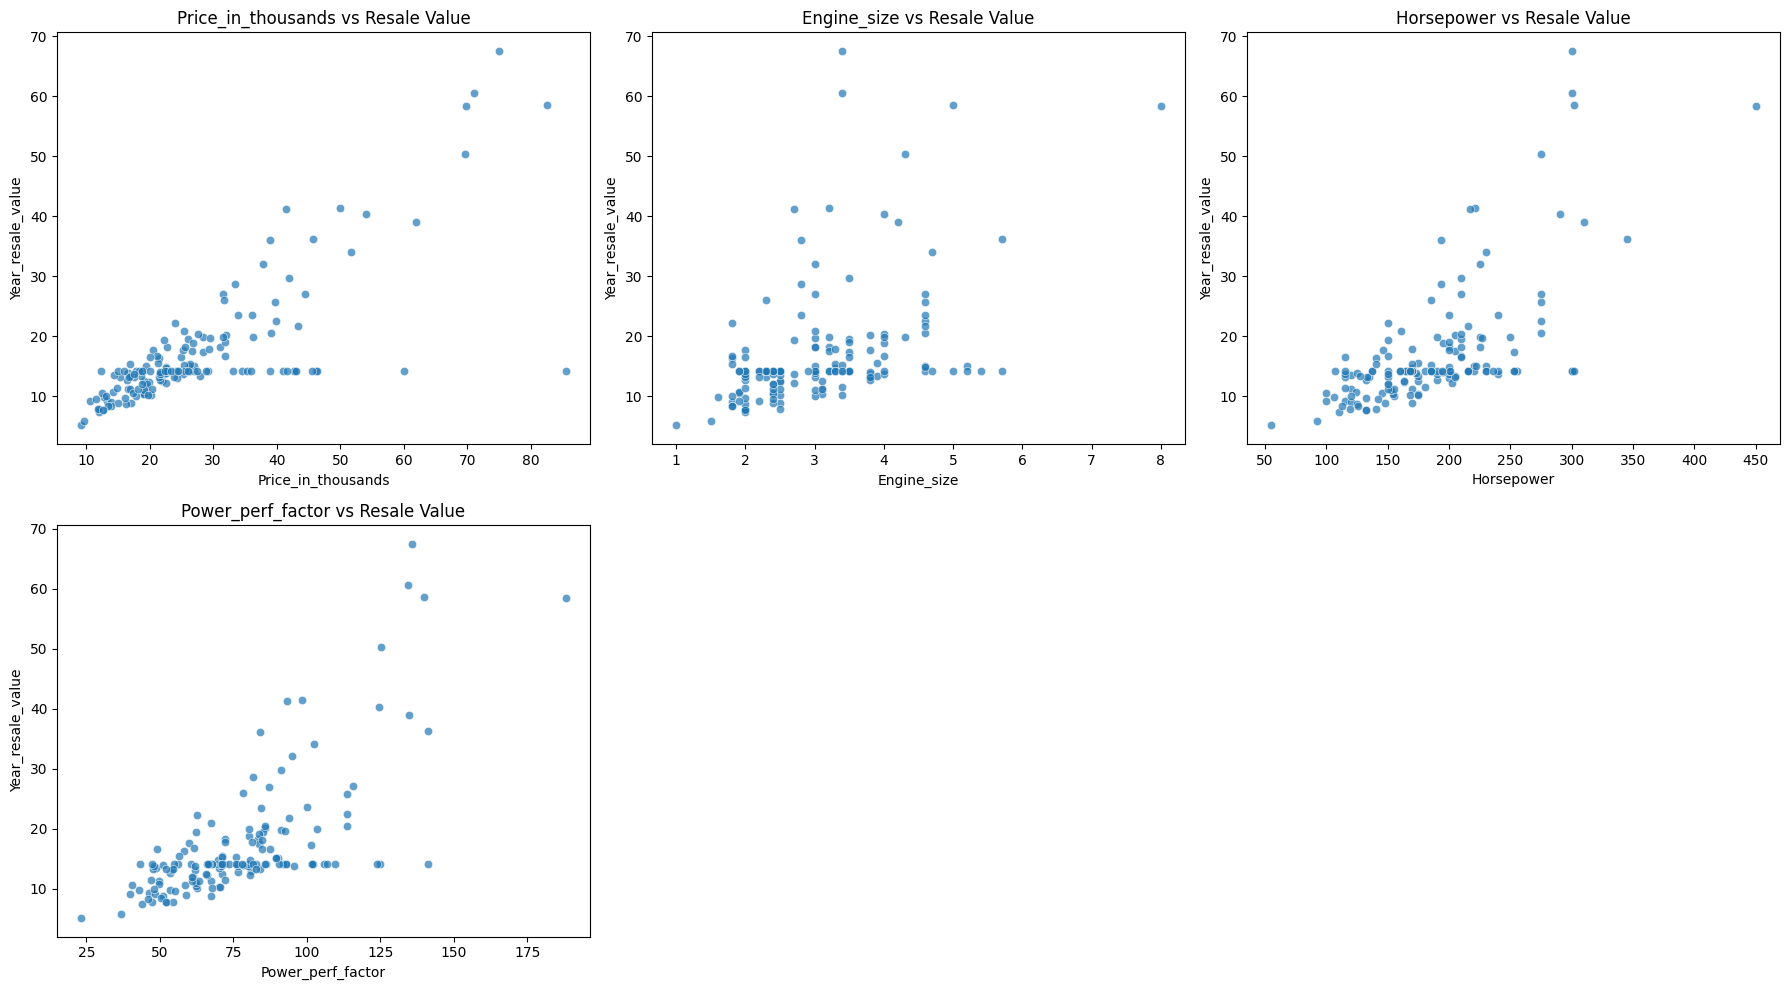

In [31]:
# Factors influencing car resales

# Step 1: Numeric features including target Resale value
numeric_cols = df.select_dtypes(include=np.number).columns

# Step 2: Correlation matrix
corr_matrix = df[numeric_cols].corr().round(1)

# Step 3: Extract correlations with Resale value
price_corr = corr_matrix["Year_resale_value"].drop("Year_resale_value")

# Step 4: Select features with |correlation| > 0.5
selected_price_features = price_corr[price_corr.abs() >= 0.5].index.tolist()

print("Selected price-driving features:", selected_price_features)

# Pairplot of selected features + Resale value
sns.pairplot(df[selected_price_features + ["Year_resale_value"]])
plt.suptitle("Pairplots of Selected Numeric Features vs Resale Value", y=1.02)
plt.show()

# Scatterplots: all selected features vs Resale value in one figure
n_features = len(selected_price_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols  # auto-calc rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()

for i, feature in enumerate(selected_price_features):
    sns.scatterplot(x=feature, y="Year_resale_value", data=df, ax=axes[i], alpha=0.7)
    axes[i].set_title(f"{feature} vs Resale Value")

# Hide unused axes (if features < grid size)
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

                     mean   median      max    min  count
Price_Category                                           
Economy         73.244036  42.6430  247.994  1.112     55
Mid-range       51.740416  30.6960  540.561  0.110     77
Premium         12.368650   9.4805   48.911  0.916     20
Luxury           1.852750   1.5730    3.311  0.954      4


/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/781000356.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sales_summary = df.groupby("Price_Category")["Sales_in_thousands"].agg(["mean","median","max","min","count"])
/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/781000356.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Price_Category", y="Sales_in_thousands", data=df, estimator=np.mean, ci=None)


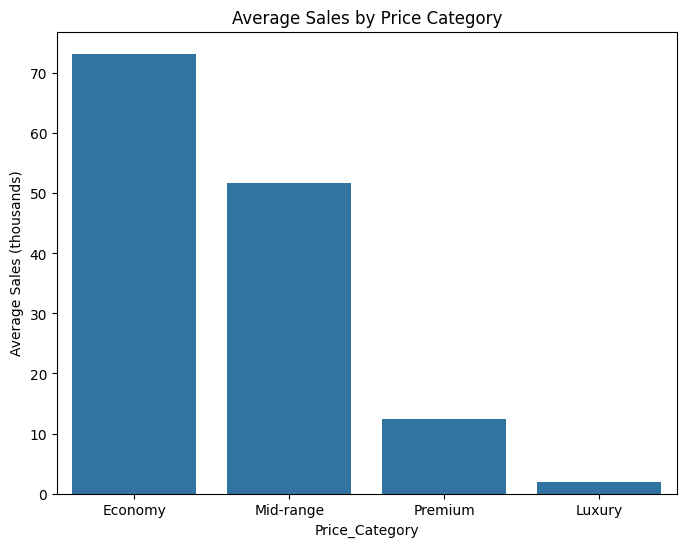

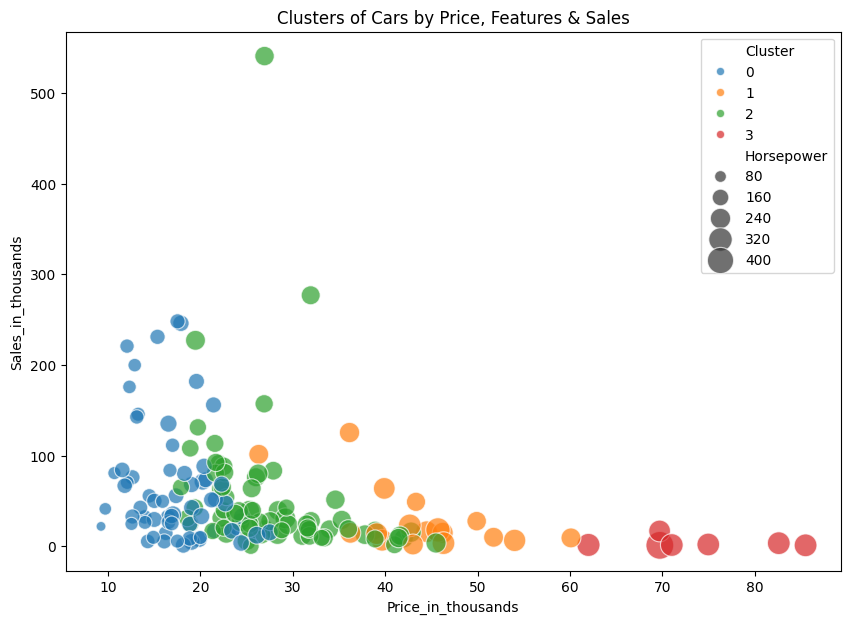

            Manufacturer           Model  Price_in_thousands  \
Cluster                                                        
0       137       Toyota           Camry              17.518   
        49          Ford          Taurus              17.885   
        58         Honda          Accord              15.350   
1       54          Ford      Expedition              36.135   
        44         Dodge         Durango              26.310   
        14      Cadillac         DeVille              39.895   
2       56          Ford        F-Series              26.935   
        52          Ford        Explorer              31.930   
        40         Dodge      Ram Pickup              19.460   
3       94    Mercedes-B         S-Class              69.700   
        95    Mercedes-B        SL-Class              82.600   
        126      Porsche  Carrera Cabrio              74.970   

             Sales_in_thousands  
Cluster                          
0       137             247.994  
 

/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/781000356.py:48: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_models = df.groupby("Cluster").apply(lambda g: g.nlargest(3, "Sales_in_thousands")[["Manufacturer","Model","Price_in_thousands","Sales_in_thousands"]])


In [32]:
# Are higher-priced cars sold less than mid-range or economy cars?
# Sales by Price Category
df["Price_Category"] = pd.cut(df["Price_in_thousands"], bins=[0,20,40,70,150], labels=["Economy","Mid-range","Premium","Luxury"])

# Average and median sales by price category
sales_summary = df.groupby("Price_Category")["Sales_in_thousands"].agg(["mean","median","max","min","count"])
print(sales_summary)

# Optional: Bar plot of mean sales
plt.figure(figsize=(8,6))
sns.barplot(x="Price_Category", y="Sales_in_thousands", data=df, estimator=np.mean, ci=None)
plt.title("Average Sales by Price Category")
plt.ylabel("Average Sales (thousands)")
plt.show()

# Are there clusters of top-selling models by price and feature set?
# 5. Clusters / Top-Selling Models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select relevant features for clustering
X = df[["Price_in_thousands","Sales_in_thousands","Horsepower","Engine_size"]].dropna()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize clusters
plt.figure(figsize=(10,7))
sns.scatterplot(
    x="Price_in_thousands",
    y="Sales_in_thousands",
    hue="Cluster",
    size="Horsepower",
    data=df,
    palette="tab10",
    alpha=0.7,
    sizes=(50, 400)
)
plt.title("Clusters of Cars by Price, Features & Sales")
plt.show()

# Show top models in each cluster
top_models = df.groupby("Cluster").apply(lambda g: g.nlargest(3, "Sales_in_thousands")[["Manufacturer","Model","Price_in_thousands","Sales_in_thousands"]])
print(top_models)



/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/2454978849.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_summary = df.groupby("Manufacturer")["Value_Retention"].mean().sort_values(ascending=False)
/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/2454978849.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=retention_summary.index, y=retention_summary.values, palette="viridis")


Manufacturer
Porsche       0.916772
Saturn        0.831697
Volkswagen    0.809297
Honda         0.779058
BMW           0.770859
Toyota        0.770020
Jeep          0.756136
Audi          0.750175
Acura         0.741967
Mercury       0.669618
Name: Value_Retention, dtype: float64


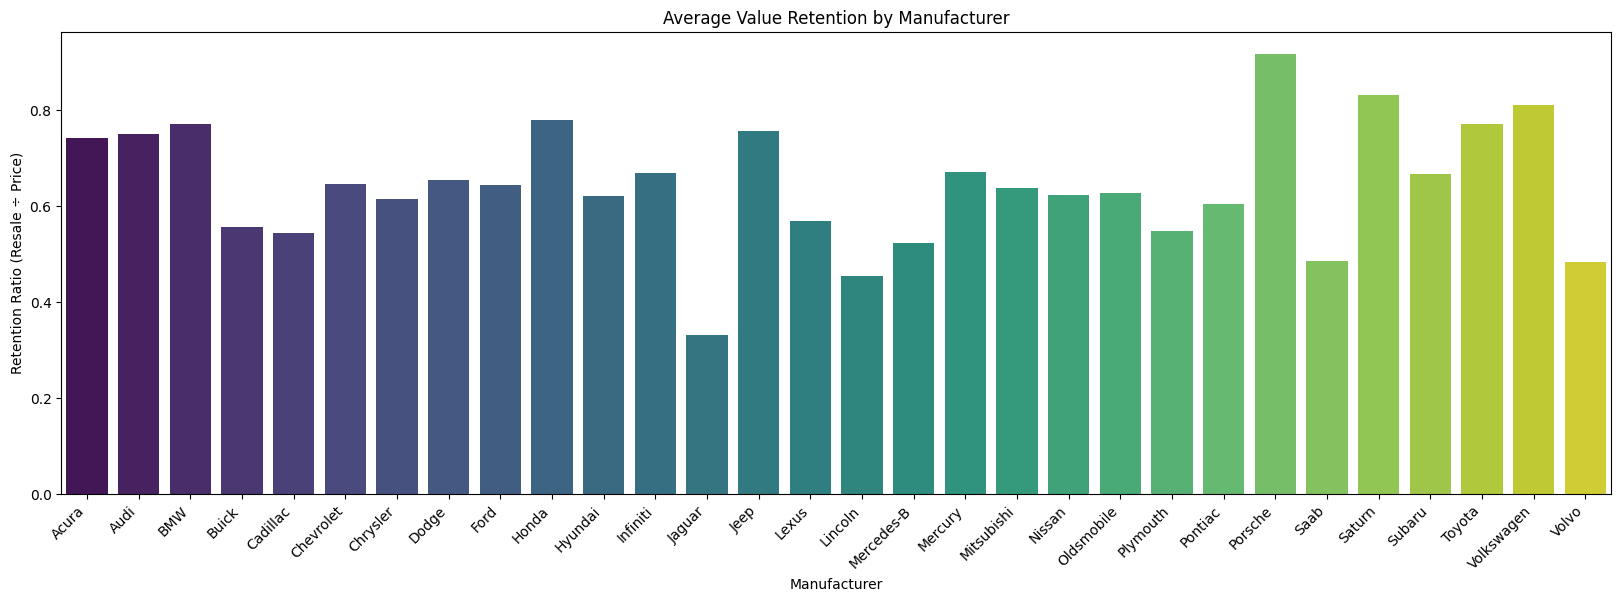

In [33]:
# Which manufacturers retain value best (Year_resale_value vs Price)?

# Value Retention (% of original price)
df["Value_Retention"] = df["Year_resale_value"] / df["Price_in_thousands"]

# Average retention by manufacturer
retention_summary = df.groupby("Manufacturer")["Value_Retention"].mean().sort_values(ascending=False)
print(retention_summary.head(10))

# Plot retention percentage
plt.figure(figsize=(20,6))
sns.barplot(x=retention_summary.index, y=retention_summary.values, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Average Value Retention by Manufacturer")
plt.ylabel("Retention Ratio (Resale ÷ Price)")
plt.xlabel("Manufacturer")
plt.show()


/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/2284979122.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Vehicle_type", y="Value_Retention", data=df, palette="Set2")


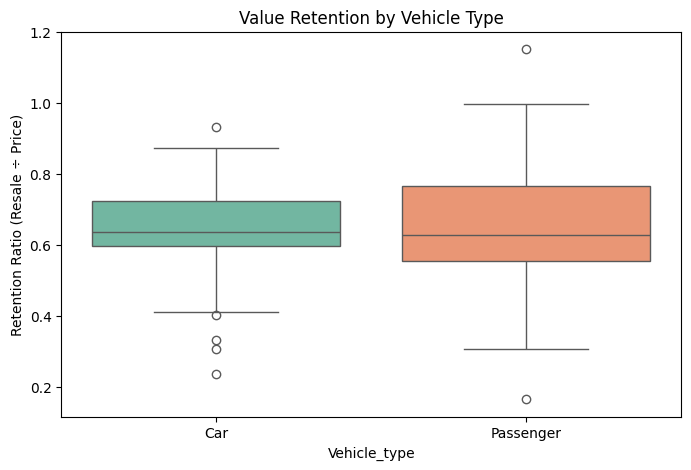

Vehicle_type
Car          0.634996
Passenger    0.652023
Name: Value_Retention, dtype: float64


/var/folders/6k/b0rqkgcn77g39rb5g8zn55zc0000gn/T/ipykernel_44304/2284979122.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby("Vehicle_type")["Value_Retention"].mean())


In [34]:
# Does vehicle type (Passenger vs Car) affect depreciation?
plt.figure(figsize=(8,5))
sns.boxplot(x="Vehicle_type", y="Value_Retention", data=df, palette="Set2")
plt.title("Value Retention by Vehicle Type")
plt.ylabel("Retention Ratio (Resale ÷ Price)")
plt.show()

print(df.groupby("Vehicle_type")["Value_Retention"].mean())
